In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

## Load extracted features and df

In [4]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [5]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 1), 'features')

def load_subject_time_feature(subj, time_steps, normalize=True):
    feature_loaded = []
    subj_result_folder = os.path.join(DEFAULT_FEATURE_FOLDER, f'{int(subj)}')
    subj_combined_feature_path = os.path.join(subj_result_folder, 'combined')
    for tid in time_steps:
        loaded = np.load(os.path.join(subj_combined_feature_path, f'{tid}.npy'))
        feature_loaded.append(loaded)
    features = np.mean(feature_loaded, axis=0) # time average

    if normalize:
        # Z-score normalization
        means = np.mean(features, axis=0)  # Mean of each column
        stds = np.std(features, axis=0)    # Standard deviation of each column
        features = (features - means) / (stds + 1e-5)
        
    # also the behavior data
    behavior_data = pd.read_csv(os.path.join(subj_result_folder, 'behavior.csv'))

    return features, behavior_data

In [6]:
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

## Precompute the difference table

In [7]:
from utils.distrib import ValueRangeManager, OriDistribModel, incorporate_distributions
from copy import deepcopy

example_base_params = {"w": 0.14, "k_base": 27, "alpha": 1.0, "beta": 0.0,}
value_manager = ValueRangeManager(np.arange(180))
base_distrib = OriDistribModel(value_manager, example_base_params)

In [8]:
all_oris = np.arange(180)
all_distrib = base_distrib.loc(all_oris)

In [9]:
# apply some smoothing
from scipy.ndimage import gaussian_filter1d

def gaussian_filter_distrib(distrib, sigma):
    smoothed = gaussian_filter1d(distrib, sigma=sigma, axis=1, mode='wrap')
    smoothed = smoothed / np.sum(smoothed, axis=1, keepdims=True)
    return smoothed

# all_distrib = gaussian_filter_distrib(all_distrib, sigma=15)

In [10]:
from scipy.spatial.distance import pdist, cdist, jensenshannon, squareform

def precomput_stim_dists(distrib, method):
    if method == 'jsd':
        dists = squareform(pdist(distrib, metric=jensenshannon))
        dists = dists / np.log(2)
    elif method == 'cos':
        distrib_normalized = distrib / np.linalg.norm(distrib, axis=1, keepdims=True)
        similarity = np.dot(distrib_normalized, distrib_normalized.T)
        dists = 1 - similarity
    elif method == 'euc':
        dists = cdist(distrib, distrib, 'euclidean')
    else:
        raise ValueError(f'Unknown method {method}')

    return dists

(array([  636.,   614.,   644.,   584.,   654.,   620.,   624.,   654.,
          672.,   672.,   718.,   736.,   798.,   844.,   918.,   998.,
         1142.,  1408.,  2364., 16100.]),
 array([0.        , 0.05217422, 0.10434844, 0.15652265, 0.20869687,
        0.26087109, 0.31304531, 0.36521952, 0.41739374, 0.46956796,
        0.52174218, 0.5739164 , 0.62609061, 0.67826483, 0.73043905,
        0.78261327, 0.83478748, 0.8869617 , 0.93913592, 0.99131014,
        1.04348435]),
 <BarContainer object of 20 artists>)

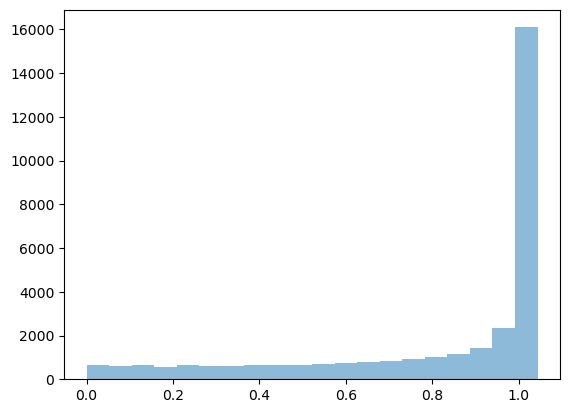

In [11]:
all_ori_dists = precomput_stim_dists(all_distrib, 'jsd')
plt.hist(all_ori_dists.flatten(), bins=20, alpha=0.5)

## Apply RSA within a certain condition

In [ ]:
from copy import deepcopy

In [ ]:
from utils.rsa import RepresentationModel

distrib_params = {"w": 0.14, "k_base": 27, "alpha": 1.0, "beta": 0.0,}
RepModel = RepresentationModel(distrib_params)

In [ ]:
from utils.rsa import RepRSAHelper

rsa_configs = {
    "channels": 18, # number of channels
    "channel_k": 5, # to compute weight for channels
}
rsa_helper = RepRSAHelper(**rsa_configs, rep_model=RepModel)

In [38]:
from utils.rsa import ALL_TIME_STEPS, raw_conditional_rsa_subj

def conditional_rsa_subj(
        subj, lmb, feature_mask, y_name, feature_dist_method):
    return raw_conditional_rsa_subj(
        subj, lmb, feature_mask, y_name, feature_dist_method,
        load_subject_time_feature, rsa_helper,
        time_steps=ALL_TIME_STEPS)

In [ ]:
draw_lmb = lambda d: (d['mode'] == 'draw').to_numpy()
feature_mask = np.arange(0, 2)
example_results = conditional_rsa_subj(908, draw_lmb, feature_mask, 'stim_1', 'euc')

## Combine everyone

In [19]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'rsa', 'within_group')

In [39]:
from utils.rsa import raw_get_everyone_corr

def get_everyone_corr(lmb, feature_mask, y_name, feature_dist_method):
    return raw_get_everyone_corr(
        lmb, feature_mask, y_name, feature_dist_method,
        compute_subj_rsa_func=conditional_rsa_subj, 
        subjs=all_subjs)

In [40]:
from collections import OrderedDict
from utils.eye_plotting import annotate_time_line
from utils.eye_trial import generate_events

EVENTS = generate_events()

In [41]:
from utils.rsa import raw_display_conditional_rsa

def display_conditional_rsa(ax, lmb, lmb_name, feature_mask, y_name, feature_dist_method, 
        color=None, alpha=1.0, linestyle='-'):
    return raw_display_conditional_rsa(
        ax, lmb, lmb_name, feature_mask, y_name, feature_dist_method, 
        color=color, alpha=alpha, linestyle=linestyle,
        get_rsa_corr_func=get_everyone_corr,
        display_time_steps=(ALL_TIME_STEPS+0.5)*50)

In [42]:
from utils.rsa import raw_display_lmb_dicts_rsa

def display_lmb_dicts_rsa(ax, lmb_dicts, feature_mask, y_name, feature_dist_method, 
        colors=None, alphas=None, linestyles=None, show_legend=True):
    return raw_display_lmb_dicts_rsa(
        ax, lmb_dicts, feature_mask, y_name, feature_dist_method, 
        colors=colors, alphas=alphas, linestyles=linestyles,
        show_legend=show_legend,
        display_rsa_func=display_conditional_rsa)

In [26]:
draw_lmb = lambda d: (d['mode'] == 'draw').to_numpy()
click_lmb = lambda d: (d['mode'] == 'click').to_numpy()

In [27]:
ALL_FEATURE_MASKS = OrderedDict([
    ('mean location', np.arange(0, 2)),
    ('angle distrib', np.arange(2, 32)),
])

ALL_FEATURE_MASK_DIST_METHODS = OrderedDict([
    ('mean location', 'euc'),
    ('angle distrib', 'cos'),
])

### sanity check

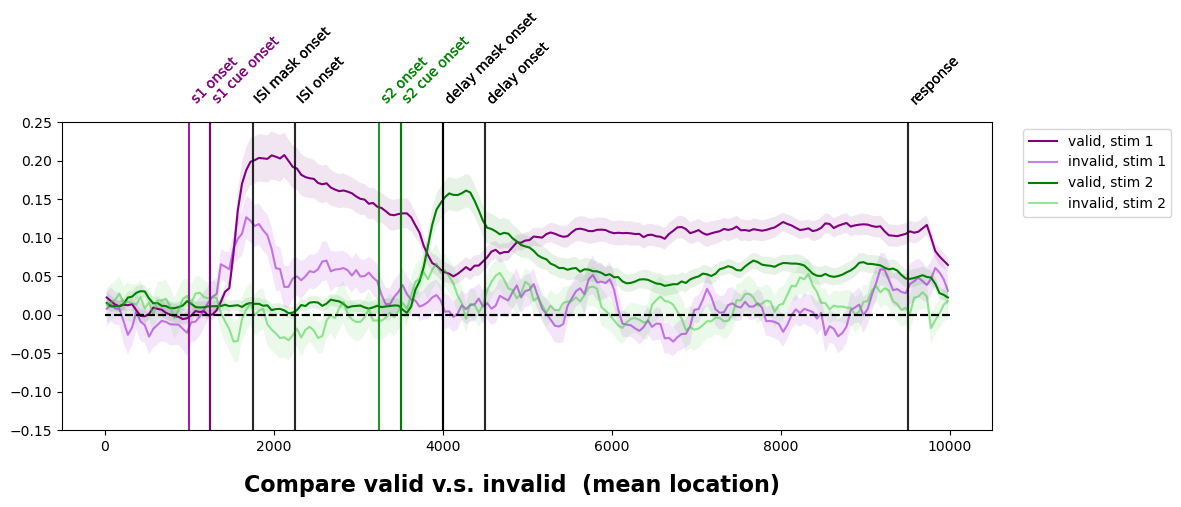

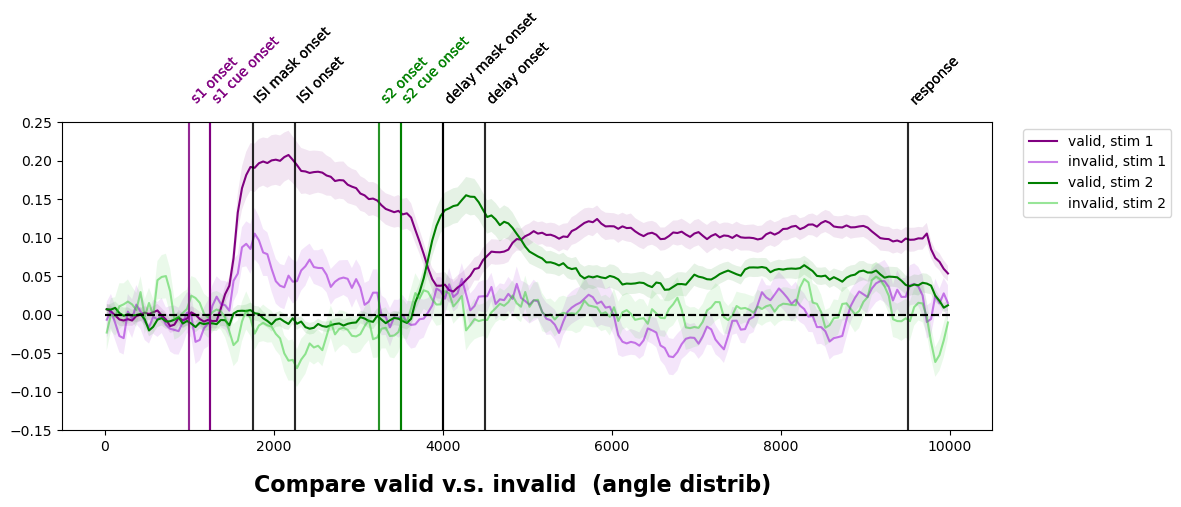

In [ ]:
stim1_valid_lmb = lambda d: ((d['stim_1_to_report'] | (d['trial_code'] == 1))).to_numpy()
stim1_invalid_lmb = lambda d: (~(stim1_valid_lmb(d)))
stim2_valid_lmb = lambda d: ((d['stim_2_to_report'] | (d['trial_code'] == 1))).to_numpy()
stim2_invalid_lmb = lambda d: (~(stim2_valid_lmb(d)))
valid_masks = {
    'stim_1': {
        'valid, stim 1': stim1_valid_lmb,
        'invalid, stim 1': stim1_invalid_lmb,
    },
    'stim_2': {
        'valid, stim 2': stim2_valid_lmb,
        'invalid, stim 2': stim2_invalid_lmb,
    }
}

valid_colors = {
    'stim_1': {
        'valid, stim 1': 'purple',
        'invalid, stim 1': 'purple',
    },
    'stim_2': {
        'valid, stim 2': 'green',
        'invalid, stim 2': 'green',
    }
}

valid_alphas = {
    'stim_1': {
        'valid, stim 1': 1.0,
        'invalid, stim 1': 0.5,
    },
    'stim_2': {
        'valid, stim 2': 1.0,
        'invalid, stim 2': 0.5,
    }
}

for feature_name in ALL_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    to_show_legend = True
    for stim_id in ['stim_1', 'stim_2']:
        display_lmb_dicts_rsa(
            ax, valid_masks[stim_id], ALL_FEATURE_MASKS[feature_name], stim_id, 
            ALL_FEATURE_MASK_DIST_METHODS[feature_name], colors=valid_colors[stim_id], 
            alphas=valid_alphas[stim_id],
            show_legend=to_show_legend)
        # to_show_legend = False
    plt.suptitle(f'Compare valid v.s. invalid  ({feature_name})', y=0, fontsize=16, fontweight='bold')

    plot_path = os.path.join(PLOTS_FOLDER, f'basic_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

### mode comparison

In [30]:
draw_stim1_lmb = lambda d: (
    (d['mode'] == 'draw') & (d['stim_1_to_report'] | (d['trial_code'] == 1))).to_numpy()
click_stim1_lmb = lambda d: (
    (d['mode'] == 'click') & (d['stim_1_to_report'] | (d['trial_code'] == 1))).to_numpy()
draw_stim2_lmb = lambda d: (
    (d['mode'] == 'draw') & (d['stim_2_to_report'] | (d['trial_code'] == 1))).to_numpy()
click_stim2_lmb = lambda d: (
    (d['mode'] == 'click') & (d['stim_2_to_report'] | (d['trial_code'] == 1))).to_numpy()

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [00:55<00:00,  1.55s/it]


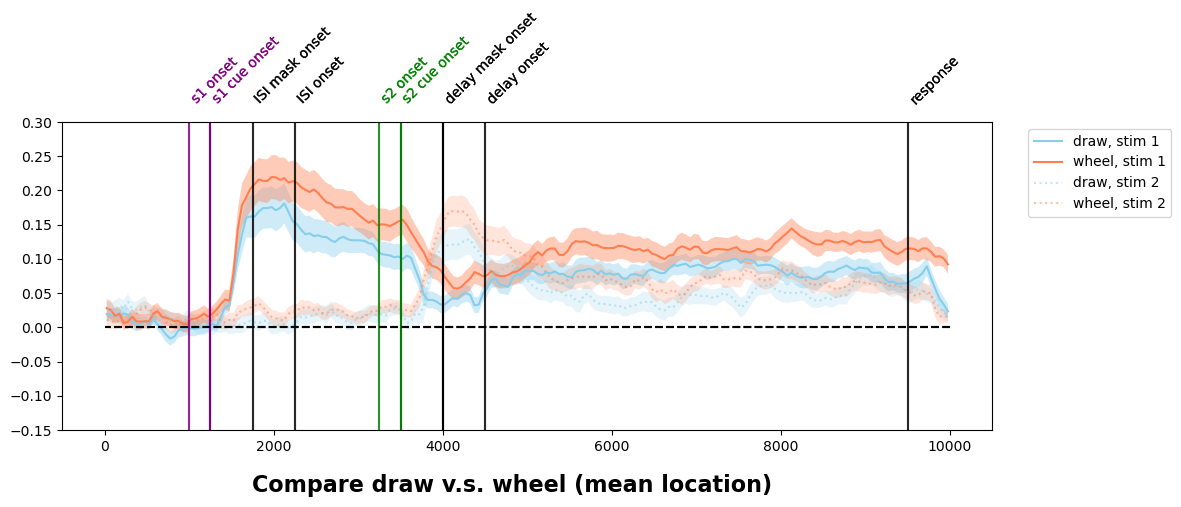

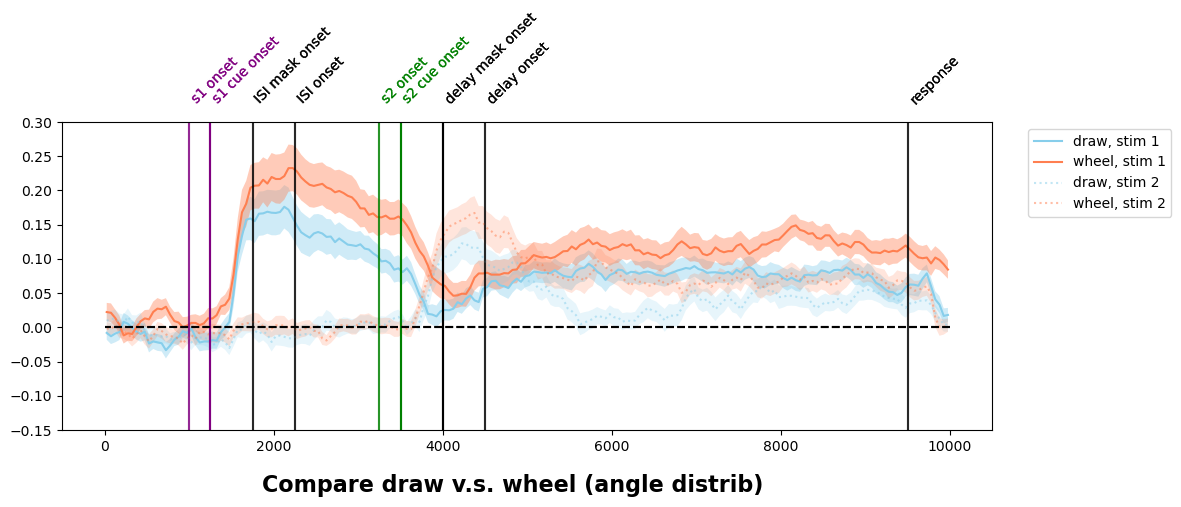

In [45]:
mode_masks = {
    'stim_1': {
        'draw, stim 1': draw_stim1_lmb,
        'wheel, stim 1': click_stim1_lmb,
    },
    'stim_2': {
        'draw, stim 2': draw_stim2_lmb,
        'wheel, stim 2': click_stim2_lmb,
    }
}

mode_colors = {
    'stim_1': {
        'draw, stim 1': 'skyblue',
        'wheel, stim 1': 'coral',
    },
    'stim_2': {
        'draw, stim 2': 'skyblue',
        'wheel, stim 2': 'coral',
    }
}

mode_alphas = {
    'stim_1': {
        'draw, stim 1': 1.0,
        'wheel, stim 1': 1.0,
    },
    'stim_2': {
        'draw, stim 2': 0.5,
        'wheel, stim 2': 0.5,
    }
}

mode_linestyles = {
    'stim_1': {
        'draw, stim 1': '-',
        'wheel, stim 1': '-',
    },
    'stim_2': {
        'draw, stim 2': ':',
        'wheel, stim 2': ':',
    }
}

for feature_name in ALL_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    to_show_legend = True
    for stim_id in ['stim_1', 'stim_2']:
        display_lmb_dicts_rsa(
            ax, mode_masks[stim_id], ALL_FEATURE_MASKS[feature_name], stim_id, 
            ALL_FEATURE_MASK_DIST_METHODS[feature_name], colors=mode_colors[stim_id], 
            alphas=mode_alphas[stim_id], linestyles=mode_linestyles[stim_id],
            show_legend=to_show_legend)
        # to_show_legend = False
    plt.suptitle(f'Compare draw v.s. wheel ({feature_name})', y=0, fontsize=16, fontweight='bold')

    plot_path = os.path.join(PLOTS_FOLDER, f'stim_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:43,  1.25s/it]


  6%|▌         | 2/36 [00:02<00:37,  1.11s/it]


  8%|▊         | 3/36 [00:03<00:37,  1.15s/it]


 11%|█         | 4/36 [00:04<00:39,  1.23s/it]


 14%|█▍        | 5/36 [00:05<00:35,  1.14s/it]


 17%|█▋        | 6/36 [00:07<00:37,  1.24s/it]


 19%|█▉        | 7/36 [00:08<00:37,  1.29s/it]


 22%|██▏       | 8/36 [00:10<00:39,  1.40s/it]


 25%|██▌       | 9/36 [00:12<00:47,  1.78s/it]


 28%|██▊       | 10/36 [00:14<00:41,  1.59s/it]


 31%|███       | 11/36 [00:15<00:35,  1.40s/it]


 33%|███▎      | 12/36 [00:16<00:35,  1.47s/it]


 36%|███▌      | 13/36 [00:18<00:34,  1.49s/it]


 39%|███▉      | 14/36 [00:19<00:33,  1.54s/it]


 42%|████▏     | 15/36 [00:20<00:28,  1.35s/it]


 44%|████▍     | 16/36 [00:21<00:25,  1.29s/it]


 47%|████▋     | 17/36 [00:23<00:26,  1.40s/it]


 50%|█████     | 18/36 [00:24<00:25,  1.40s/it]


 53%|█████▎    | 19/36 [00:26<00:22,  1.33s/it]


 56%|█████▌    | 20/36 [00:27<00:19,  1.21s/it]


 58%|█████▊    | 21/36 [00:28<00:17,  1.19s/it]


 61%|██████    | 22/36 [00:29<00:16,  1.19s/it]


 64%|██████▍   | 23/36 [00:31<00:17,  1.38s/it]


 67%|██████▋   | 24/36 [00:33<00:18,  1.51s/it]


 69%|██████▉   | 25/36 [00:34<00:15,  1.45s/it]


 72%|███████▏  | 26/36 [00:36<00:16,  1.63s/it]


 75%|███████▌  | 27/36 [00:37<00:14,  1.62s/it]


 78%|███████▊  | 28/36 [00:38<00:11,  1.41s/it]


 81%|████████  | 29/36 [00:40<00:10,  1.45s/it]


 83%|████████▎ | 30/36 [00:42<00:09,  1.59s/it]


 86%|████████▌ | 31/36 [00:43<00:08,  1.61s/it]


 89%|████████▉ | 32/36 [00:45<00:05,  1.49s/it]


 92%|█████████▏| 33/36 [00:46<00:04,  1.53s/it]


 94%|█████████▍| 34/36 [00:48<00:03,  1.57s/it]


 97%|█████████▋| 35/36 [00:49<00:01,  1.44s/it]


100%|██████████| 36/36 [00:51<00:00,  1.55s/it]


100%|██████████| 36/36 [00:51<00:00,  1.43s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:32,  1.07it/s]


  6%|▌         | 2/36 [00:01<00:32,  1.04it/s]


  8%|▊         | 3/36 [00:03<00:40,  1.21s/it]


 11%|█         | 4/36 [00:04<00:35,  1.12s/it]


 14%|█▍        | 5/36 [00:05<00:35,  1.15s/it]


 17%|█▋        | 6/36 [00:06<00:32,  1.09s/it]


 19%|█▉        | 7/36 [00:07<00:33,  1.14s/it]


 22%|██▏       | 8/36 [00:09<00:34,  1.24s/it]


 25%|██▌       | 9/36 [00:10<00:36,  1.35s/it]


 28%|██▊       | 10/36 [00:11<00:32,  1.23s/it]


 31%|███       | 11/36 [00:13<00:33,  1.34s/it]


 33%|███▎      | 12/36 [00:14<00:30,  1.28s/it]


 36%|███▌      | 13/36 [00:15<00:29,  1.30s/it]


 39%|███▉      | 14/36 [00:17<00:27,  1.27s/it]


 42%|████▏     | 15/36 [00:18<00:24,  1.17s/it]


 44%|████▍     | 16/36 [00:19<00:27,  1.36s/it]


 47%|████▋     | 17/36 [00:21<00:30,  1.59s/it]


 50%|█████     | 18/36 [00:23<00:27,  1.52s/it]


 53%|█████▎    | 19/36 [00:24<00:23,  1.41s/it]


 56%|█████▌    | 20/36 [00:25<00:21,  1.34s/it]


 58%|█████▊    | 21/36 [00:26<00:19,  1.29s/it]


 61%|██████    | 22/36 [00:28<00:20,  1.48s/it]


 64%|██████▍   | 23/36 [00:29<00:16,  1.31s/it]


 67%|██████▋   | 24/36 [00:31<00:15,  1.33s/it]


 69%|██████▉   | 25/36 [00:32<00:16,  1.49s/it]


 72%|███████▏  | 26/36 [00:34<00:14,  1.46s/it]


 75%|███████▌  | 27/36 [00:35<00:12,  1.43s/it]


 78%|███████▊  | 28/36 [00:37<00:12,  1.55s/it]


 81%|████████  | 29/36 [00:38<00:10,  1.49s/it]


 83%|████████▎ | 30/36 [00:40<00:09,  1.60s/it]


 86%|████████▌ | 31/36 [00:42<00:07,  1.53s/it]


 89%|████████▉ | 32/36 [00:43<00:05,  1.49s/it]


 92%|█████████▏| 33/36 [00:44<00:04,  1.38s/it]


 94%|█████████▍| 34/36 [00:45<00:02,  1.36s/it]


 97%|█████████▋| 35/36 [00:47<00:01,  1.43s/it]


100%|██████████| 36/36 [00:49<00:00,  1.55s/it]


100%|██████████| 36/36 [00:49<00:00,  1.37s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:48,  1.39s/it]


  6%|▌         | 2/36 [00:02<00:43,  1.28s/it]


  8%|▊         | 3/36 [00:03<00:41,  1.26s/it]


 11%|█         | 4/36 [00:05<00:39,  1.24s/it]


 14%|█▍        | 5/36 [00:06<00:40,  1.30s/it]


 17%|█▋        | 6/36 [00:08<00:42,  1.43s/it]


 19%|█▉        | 7/36 [00:09<00:41,  1.42s/it]


 22%|██▏       | 8/36 [00:10<00:37,  1.35s/it]


 25%|██▌       | 9/36 [00:13<00:45,  1.70s/it]


 28%|██▊       | 10/36 [00:14<00:41,  1.61s/it]


 31%|███       | 11/36 [00:15<00:37,  1.48s/it]


 33%|███▎      | 12/36 [00:17<00:34,  1.45s/it]


 36%|███▌      | 13/36 [00:18<00:31,  1.36s/it]


 39%|███▉      | 14/36 [00:19<00:30,  1.38s/it]


 42%|████▏     | 15/36 [00:20<00:27,  1.32s/it]


 44%|████▍     | 16/36 [00:22<00:25,  1.28s/it]


 47%|████▋     | 17/36 [00:23<00:26,  1.38s/it]


 50%|█████     | 18/36 [00:25<00:27,  1.50s/it]


 53%|█████▎    | 19/36 [00:26<00:23,  1.41s/it]


 56%|█████▌    | 20/36 [00:28<00:24,  1.55s/it]


 58%|█████▊    | 21/36 [00:29<00:22,  1.50s/it]


 61%|██████    | 22/36 [00:31<00:22,  1.60s/it]


 64%|██████▍   | 23/36 [00:32<00:19,  1.47s/it]


 67%|██████▋   | 24/36 [00:34<00:17,  1.45s/it]


 69%|██████▉   | 25/36 [00:35<00:15,  1.40s/it]


 72%|███████▏  | 26/36 [00:37<00:13,  1.39s/it]


 75%|███████▌  | 27/36 [00:39<00:14,  1.60s/it]


 78%|███████▊  | 28/36 [00:40<00:11,  1.46s/it]


 81%|████████  | 29/36 [00:42<00:10,  1.57s/it]


 83%|████████▎ | 30/36 [00:43<00:08,  1.45s/it]


 86%|████████▌ | 31/36 [00:44<00:07,  1.51s/it]


 89%|████████▉ | 32/36 [00:46<00:06,  1.53s/it]


 92%|█████████▏| 33/36 [00:47<00:04,  1.49s/it]


 94%|█████████▍| 34/36 [00:49<00:02,  1.46s/it]


 97%|█████████▋| 35/36 [00:50<00:01,  1.53s/it]


100%|██████████| 36/36 [00:52<00:00,  1.43s/it]


100%|██████████| 36/36 [00:52<00:00,  1.45s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:57,  1.63s/it]


  6%|▌         | 2/36 [00:02<00:42,  1.26s/it]


  8%|▊         | 3/36 [00:04<00:54,  1.66s/it]


 11%|█         | 4/36 [00:06<00:55,  1.72s/it]


 14%|█▍        | 5/36 [00:07<00:49,  1.60s/it]


 17%|█▋        | 6/36 [00:09<00:50,  1.69s/it]


 19%|█▉        | 7/36 [00:10<00:42,  1.45s/it]


 22%|██▏       | 8/36 [00:11<00:36,  1.30s/it]


 25%|██▌       | 9/36 [00:13<00:39,  1.47s/it]


 28%|██▊       | 10/36 [00:15<00:41,  1.59s/it]


 31%|███       | 11/36 [00:17<00:40,  1.62s/it]


 33%|███▎      | 12/36 [00:18<00:36,  1.53s/it]


 36%|███▌      | 13/36 [00:19<00:34,  1.51s/it]


 39%|███▉      | 14/36 [00:21<00:33,  1.54s/it]


 42%|████▏     | 15/36 [00:23<00:32,  1.56s/it]


 44%|████▍     | 16/36 [00:24<00:30,  1.51s/it]


 47%|████▋     | 17/36 [00:25<00:26,  1.41s/it]


 50%|█████     | 18/36 [00:27<00:25,  1.42s/it]


 53%|█████▎    | 19/36 [00:28<00:23,  1.41s/it]


 56%|█████▌    | 20/36 [00:29<00:21,  1.35s/it]


 58%|█████▊    | 21/36 [00:31<00:22,  1.51s/it]


 61%|██████    | 22/36 [00:33<00:21,  1.53s/it]


 64%|██████▍   | 23/36 [00:34<00:17,  1.35s/it]


 67%|██████▋   | 24/36 [00:35<00:17,  1.49s/it]


 69%|██████▉   | 25/36 [00:38<00:18,  1.71s/it]


 72%|███████▏  | 26/36 [00:39<00:15,  1.54s/it]


 75%|███████▌  | 27/36 [00:40<00:12,  1.43s/it]


 78%|███████▊  | 28/36 [00:41<00:10,  1.27s/it]


 81%|████████  | 29/36 [00:42<00:08,  1.24s/it]


 83%|████████▎ | 30/36 [00:43<00:06,  1.16s/it]


 86%|████████▌ | 31/36 [00:45<00:06,  1.35s/it]


 89%|████████▉ | 32/36 [00:46<00:05,  1.37s/it]


 92%|█████████▏| 33/36 [00:48<00:04,  1.46s/it]


 94%|█████████▍| 34/36 [00:49<00:02,  1.43s/it]


 97%|█████████▋| 35/36 [00:51<00:01,  1.51s/it]


100%|██████████| 36/36 [00:52<00:00,  1.41s/it]


100%|██████████| 36/36 [00:52<00:00,  1.46s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:34,  1.02it/s]


  6%|▌         | 2/36 [00:02<00:43,  1.27s/it]


  8%|▊         | 3/36 [00:03<00:42,  1.30s/it]


 11%|█         | 4/36 [00:06<00:54,  1.69s/it]


 14%|█▍        | 5/36 [00:07<00:50,  1.62s/it]


 17%|█▋        | 6/36 [00:09<00:47,  1.58s/it]


 19%|█▉        | 7/36 [00:10<00:45,  1.56s/it]


 22%|██▏       | 8/36 [00:11<00:39,  1.40s/it]


 25%|██▌       | 9/36 [00:13<00:40,  1.50s/it]


 28%|██▊       | 10/36 [00:15<00:42,  1.65s/it]


 31%|███       | 11/36 [00:16<00:38,  1.54s/it]


 33%|███▎      | 12/36 [00:17<00:35,  1.47s/it]


 36%|███▌      | 13/36 [00:19<00:31,  1.36s/it]


 39%|███▉      | 14/36 [00:20<00:28,  1.29s/it]


 42%|████▏     | 15/36 [00:21<00:28,  1.34s/it]


 44%|████▍     | 16/36 [00:23<00:28,  1.40s/it]


 47%|████▋     | 17/36 [00:24<00:26,  1.38s/it]


 50%|█████     | 18/36 [00:25<00:24,  1.38s/it]


 53%|█████▎    | 19/36 [00:27<00:22,  1.35s/it]


 56%|█████▌    | 20/36 [00:28<00:22,  1.39s/it]


 58%|█████▊    | 21/36 [00:29<00:20,  1.35s/it]


 61%|██████    | 22/36 [00:31<00:20,  1.43s/it]


 64%|██████▍   | 23/36 [00:33<00:18,  1.45s/it]


 67%|██████▋   | 24/36 [00:34<00:17,  1.49s/it]


 69%|██████▉   | 25/36 [00:35<00:15,  1.45s/it]


 72%|███████▏  | 26/36 [00:37<00:14,  1.48s/it]


 75%|███████▌  | 27/36 [00:38<00:12,  1.44s/it]


 78%|███████▊  | 28/36 [00:40<00:11,  1.41s/it]


 81%|████████  | 29/36 [00:41<00:09,  1.37s/it]


 83%|████████▎ | 30/36 [00:42<00:08,  1.41s/it]


 86%|████████▌ | 31/36 [00:45<00:08,  1.69s/it]


 89%|████████▉ | 32/36 [00:46<00:06,  1.63s/it]


 92%|█████████▏| 33/36 [00:48<00:04,  1.60s/it]


 94%|█████████▍| 34/36 [00:49<00:03,  1.56s/it]


 97%|█████████▋| 35/36 [00:50<00:01,  1.41s/it]


100%|██████████| 36/36 [00:51<00:00,  1.27s/it]


100%|██████████| 36/36 [00:51<00:00,  1.44s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:44,  1.28s/it]


  6%|▌         | 2/36 [00:02<00:40,  1.18s/it]


  8%|▊         | 3/36 [00:03<00:44,  1.35s/it]


 11%|█         | 4/36 [00:05<00:42,  1.32s/it]


 14%|█▍        | 5/36 [00:06<00:38,  1.25s/it]


 17%|█▋        | 6/36 [00:07<00:36,  1.21s/it]


 19%|█▉        | 7/36 [00:08<00:35,  1.23s/it]


 22%|██▏       | 8/36 [00:09<00:33,  1.19s/it]


 25%|██▌       | 9/36 [00:10<00:31,  1.16s/it]


 28%|██▊       | 10/36 [00:12<00:32,  1.26s/it]


 31%|███       | 11/36 [00:14<00:35,  1.43s/it]


 33%|███▎      | 12/36 [00:15<00:31,  1.32s/it]


 36%|███▌      | 13/36 [00:16<00:28,  1.25s/it]


 39%|███▉      | 14/36 [00:17<00:29,  1.32s/it]


 42%|████▏     | 15/36 [00:19<00:30,  1.43s/it]


 44%|████▍     | 16/36 [00:21<00:30,  1.55s/it]


 47%|████▋     | 17/36 [00:22<00:26,  1.41s/it]


 50%|█████     | 18/36 [00:23<00:23,  1.31s/it]


 53%|█████▎    | 19/36 [00:24<00:22,  1.30s/it]


 56%|█████▌    | 20/36 [00:25<00:19,  1.24s/it]


 58%|█████▊    | 21/36 [00:27<00:18,  1.21s/it]


 61%|██████    | 22/36 [00:28<00:18,  1.32s/it]


 64%|██████▍   | 23/36 [00:29<00:16,  1.23s/it]


 67%|██████▋   | 24/36 [00:30<00:14,  1.19s/it]


 69%|██████▉   | 25/36 [00:31<00:12,  1.12s/it]


 72%|███████▏  | 26/36 [00:32<00:11,  1.11s/it]


 75%|███████▌  | 27/36 [00:34<00:10,  1.18s/it]


 78%|███████▊  | 28/36 [00:35<00:08,  1.12s/it]


 81%|████████  | 29/36 [00:36<00:07,  1.12s/it]


 83%|████████▎ | 30/36 [00:37<00:06,  1.10s/it]


 86%|████████▌ | 31/36 [00:38<00:05,  1.10s/it]


 89%|████████▉ | 32/36 [00:39<00:04,  1.23s/it]


 92%|█████████▏| 33/36 [00:41<00:03,  1.24s/it]


 94%|█████████▍| 34/36 [00:42<00:02,  1.26s/it]


 97%|█████████▋| 35/36 [00:43<00:01,  1.26s/it]


100%|██████████| 36/36 [00:45<00:00,  1.29s/it]


100%|██████████| 36/36 [00:45<00:00,  1.25s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:38,  1.11s/it]


  6%|▌         | 2/36 [00:03<00:53,  1.58s/it]


  8%|▊         | 3/36 [00:04<00:45,  1.37s/it]


 11%|█         | 4/36 [00:05<00:42,  1.34s/it]


 14%|█▍        | 5/36 [00:06<00:38,  1.24s/it]


 17%|█▋        | 6/36 [00:07<00:35,  1.20s/it]


 19%|█▉        | 7/36 [00:08<00:33,  1.16s/it]


 22%|██▏       | 8/36 [00:09<00:31,  1.14s/it]


 25%|██▌       | 9/36 [00:10<00:29,  1.11s/it]


 28%|██▊       | 10/36 [00:11<00:28,  1.10s/it]


 31%|███       | 11/36 [00:12<00:27,  1.08s/it]


 33%|███▎      | 12/36 [00:14<00:27,  1.14s/it]


 36%|███▌      | 13/36 [00:15<00:25,  1.10s/it]


 39%|███▉      | 14/36 [00:16<00:24,  1.11s/it]


 42%|████▏     | 15/36 [00:17<00:22,  1.09s/it]


 44%|████▍     | 16/36 [00:18<00:21,  1.09s/it]


 47%|████▋     | 17/36 [00:19<00:21,  1.13s/it]


 50%|█████     | 18/36 [00:21<00:21,  1.19s/it]


 53%|█████▎    | 19/36 [00:22<00:20,  1.22s/it]


 56%|█████▌    | 20/36 [00:23<00:18,  1.18s/it]


 58%|█████▊    | 21/36 [00:24<00:17,  1.13s/it]


 61%|██████    | 22/36 [00:25<00:15,  1.11s/it]


 64%|██████▍   | 23/36 [00:26<00:14,  1.10s/it]


 67%|██████▋   | 24/36 [00:27<00:13,  1.08s/it]


 69%|██████▉   | 25/36 [00:28<00:11,  1.04s/it]


 72%|███████▏  | 26/36 [00:29<00:10,  1.08s/it]


 75%|███████▌  | 27/36 [00:30<00:09,  1.09s/it]


 78%|███████▊  | 28/36 [00:31<00:08,  1.07s/it]


 81%|████████  | 29/36 [00:32<00:07,  1.08s/it]


 83%|████████▎ | 30/36 [00:34<00:06,  1.07s/it]


 86%|████████▌ | 31/36 [00:35<00:05,  1.08s/it]


 89%|████████▉ | 32/36 [00:36<00:04,  1.09s/it]


 92%|█████████▏| 33/36 [00:37<00:03,  1.08s/it]


 94%|█████████▍| 34/36 [00:38<00:02,  1.14s/it]


 97%|█████████▋| 35/36 [00:39<00:01,  1.14s/it]


100%|██████████| 36/36 [00:40<00:00,  1.11s/it]


100%|██████████| 36/36 [00:40<00:00,  1.13s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:46,  1.33s/it]


  6%|▌         | 2/36 [00:02<00:41,  1.21s/it]


  8%|▊         | 3/36 [00:03<00:41,  1.26s/it]


 11%|█         | 4/36 [00:04<00:37,  1.16s/it]


 14%|█▍        | 5/36 [00:06<00:40,  1.30s/it]


 17%|█▋        | 6/36 [00:07<00:39,  1.30s/it]


 19%|█▉        | 7/36 [00:08<00:35,  1.22s/it]


 22%|██▏       | 8/36 [00:09<00:32,  1.17s/it]


 25%|██▌       | 9/36 [00:10<00:30,  1.14s/it]


 28%|██▊       | 10/36 [00:11<00:29,  1.14s/it]


 31%|███       | 11/36 [00:13<00:28,  1.14s/it]


 33%|███▎      | 12/36 [00:14<00:27,  1.16s/it]


 36%|███▌      | 13/36 [00:15<00:27,  1.19s/it]


 39%|███▉      | 14/36 [00:16<00:27,  1.23s/it]


 42%|████▏     | 15/36 [00:17<00:24,  1.18s/it]


 44%|████▍     | 16/36 [00:19<00:23,  1.16s/it]


 47%|████▋     | 17/36 [00:20<00:22,  1.19s/it]


 50%|█████     | 18/36 [00:21<00:23,  1.30s/it]


 53%|█████▎    | 19/36 [00:22<00:20,  1.22s/it]


 56%|█████▌    | 20/36 [00:24<00:19,  1.25s/it]


 58%|█████▊    | 21/36 [00:25<00:17,  1.19s/it]


 61%|██████    | 22/36 [00:26<00:16,  1.15s/it]


 64%|██████▍   | 23/36 [00:27<00:14,  1.13s/it]


 67%|██████▋   | 24/36 [00:28<00:13,  1.13s/it]


 69%|██████▉   | 25/36 [00:29<00:11,  1.08s/it]


 72%|███████▏  | 26/36 [00:30<00:10,  1.08s/it]


 75%|███████▌  | 27/36 [00:31<00:09,  1.08s/it]


 78%|███████▊  | 28/36 [00:32<00:08,  1.05s/it]


 81%|████████  | 29/36 [00:33<00:07,  1.06s/it]


 83%|████████▎ | 30/36 [00:34<00:06,  1.05s/it]


 86%|████████▌ | 31/36 [00:35<00:05,  1.07s/it]


 89%|████████▉ | 32/36 [00:36<00:04,  1.08s/it]


 92%|█████████▏| 33/36 [00:38<00:03,  1.08s/it]


 94%|█████████▍| 34/36 [00:39<00:02,  1.09s/it]


 97%|█████████▋| 35/36 [00:40<00:01,  1.08s/it]


100%|██████████| 36/36 [00:41<00:00,  1.08s/it]


100%|██████████| 36/36 [00:41<00:00,  1.15s/it]

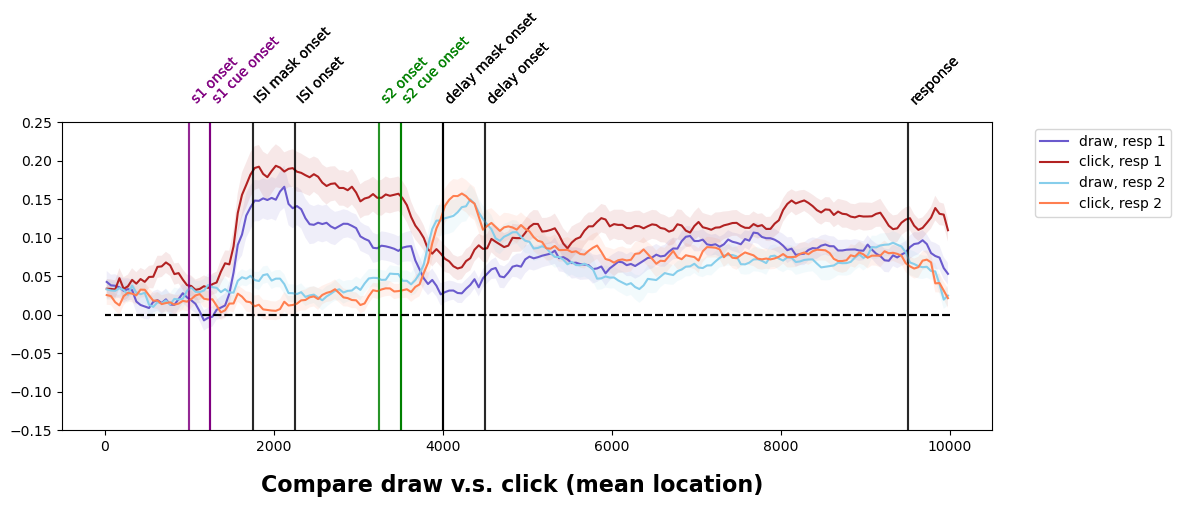

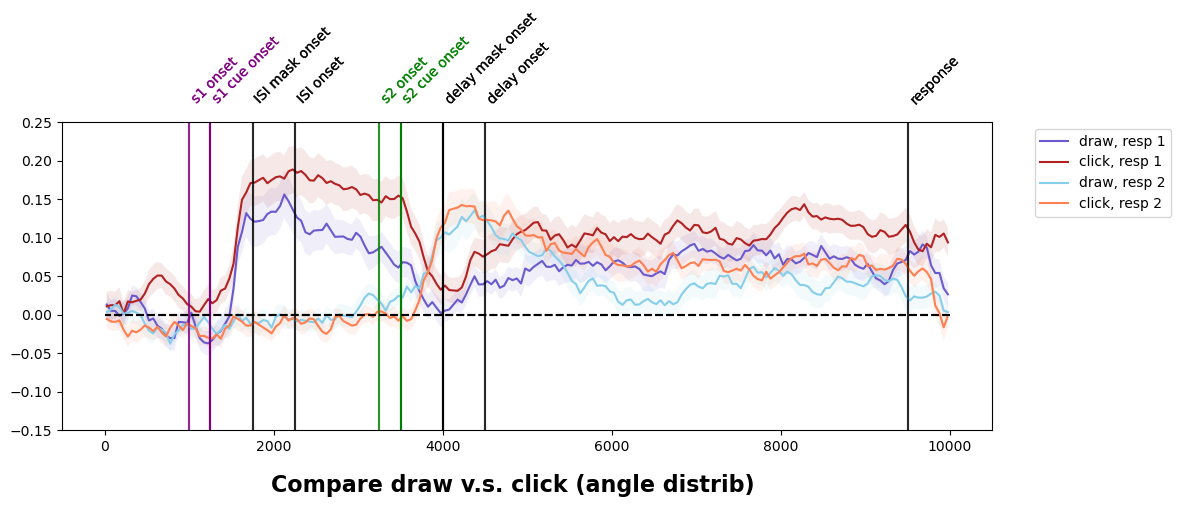

In [ ]:
mode_masks = {
    'resp_1': {
        'draw, resp 1': draw_stim1_lmb,
        'click, resp 1': click_stim1_lmb,
    },
    'resp_2': {
        'draw, resp 2': draw_stim2_lmb,
        'click, resp 2': click_stim2_lmb,
    }
}

mode_colors = {
    'resp_1': {
        'draw, resp 1': 'skyblue',
        'click, resp 1': 'coral',
    },
    'resp_2': {
        'draw, resp 2': 'skyblue',
        'click, resp 2': 'coral',
    }
}

mode_alphas = {
    'resp_1': {
        'draw, resp 1': 1.0,
        'click, resp 1': 1.0,
    },
    'resp_2': {
        'draw, resp 2': 0.5,
        'click, resp 2': 0.5,
    }
}

mode_linestyles = {
    'resp_1': {
        'draw, resp 1': '-',
        'click, resp 1': '-',
    },
    'resp_2': {
        'draw, resp 2': ':',
        'click, resp 2': ':',
    }
}

for feature_name in ALL_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    to_show_legend = True
    for stim_id in ['resp_1', 'resp_2']:
        display_lmb_dicts_rsa(
            ax, mode_masks[stim_id], ALL_FEATURE_MASKS[feature_name], stim_id, 
            ALL_FEATURE_MASK_DIST_METHODS[feature_name], colors=mode_colors[stim_id], 
            alphas=mode_alphas[stim_id], linestyles=mode_linestyles[stim_id],
            show_legend=to_show_legend)
        # to_show_legend = False
    plt.suptitle(f'Compare draw v.s. click ({feature_name})', y=0, fontsize=16, fontweight='bold')

    plot_path = os.path.join(PLOTS_FOLDER, f'resp_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:48,  1.37s/it]


  6%|▌         | 2/36 [00:02<00:38,  1.13s/it]


  8%|▊         | 3/36 [00:03<00:34,  1.06s/it]


 11%|█         | 4/36 [00:04<00:38,  1.20s/it]


 14%|█▍        | 5/36 [00:05<00:34,  1.11s/it]


 17%|█▋        | 6/36 [00:06<00:31,  1.07s/it]


 19%|█▉        | 7/36 [00:07<00:29,  1.03s/it]


 22%|██▏       | 8/36 [00:08<00:28,  1.01s/it]


 25%|██▌       | 9/36 [00:09<00:26,  1.01it/s]


 28%|██▊       | 10/36 [00:10<00:25,  1.02it/s]


 31%|███       | 11/36 [00:11<00:24,  1.03it/s]


 33%|███▎      | 12/36 [00:12<00:23,  1.03it/s]


 36%|███▌      | 13/36 [00:13<00:23,  1.02s/it]


 39%|███▉      | 14/36 [00:14<00:21,  1.01it/s]


 42%|████▏     | 15/36 [00:15<00:20,  1.03it/s]


 44%|████▍     | 16/36 [00:16<00:19,  1.03it/s]


 47%|████▋     | 17/36 [00:17<00:18,  1.03it/s]


 50%|█████     | 18/36 [00:18<00:18,  1.02s/it]


 53%|█████▎    | 19/36 [00:19<00:18,  1.07s/it]


 56%|█████▌    | 20/36 [00:20<00:16,  1.04s/it]


 58%|█████▊    | 21/36 [00:21<00:15,  1.01s/it]


 61%|██████    | 22/36 [00:22<00:13,  1.01it/s]


 64%|██████▍   | 23/36 [00:23<00:12,  1.03it/s]


 67%|██████▋   | 24/36 [00:24<00:11,  1.03it/s]


 69%|██████▉   | 25/36 [00:25<00:10,  1.07it/s]


 72%|███████▏  | 26/36 [00:26<00:09,  1.06it/s]


 75%|███████▌  | 27/36 [00:27<00:08,  1.05it/s]


 78%|███████▊  | 28/36 [00:28<00:07,  1.01it/s]


 81%|████████  | 29/36 [00:29<00:06,  1.03it/s]


 83%|████████▎ | 30/36 [00:30<00:05,  1.04it/s]


 86%|████████▌ | 31/36 [00:31<00:04,  1.04it/s]


 89%|████████▉ | 32/36 [00:32<00:04,  1.02s/it]


 92%|█████████▏| 33/36 [00:33<00:03,  1.07s/it]


 94%|█████████▍| 34/36 [00:34<00:02,  1.02s/it]


 97%|█████████▋| 35/36 [00:35<00:01,  1.06s/it]


100%|██████████| 36/36 [00:36<00:00,  1.02s/it]


100%|██████████| 36/36 [00:36<00:00,  1.01s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:33,  1.05it/s]


  6%|▌         | 2/36 [00:01<00:32,  1.05it/s]


  8%|▊         | 3/36 [00:02<00:31,  1.04it/s]


 11%|█         | 4/36 [00:03<00:30,  1.05it/s]


 14%|█▍        | 5/36 [00:04<00:29,  1.04it/s]


 17%|█▋        | 6/36 [00:05<00:29,  1.03it/s]


 19%|█▉        | 7/36 [00:06<00:30,  1.04s/it]


 22%|██▏       | 8/36 [00:08<00:30,  1.09s/it]


 25%|██▌       | 9/36 [00:09<00:28,  1.05s/it]


 28%|██▊       | 10/36 [00:10<00:28,  1.09s/it]


 31%|███       | 11/36 [00:11<00:26,  1.05s/it]


 33%|███▎      | 12/36 [00:12<00:24,  1.00s/it]


 36%|███▌      | 13/36 [00:13<00:22,  1.02it/s]


 39%|███▉      | 14/36 [00:14<00:21,  1.02it/s]


 42%|████▏     | 15/36 [00:14<00:19,  1.05it/s]


 44%|████▍     | 16/36 [00:16<00:21,  1.07s/it]


 47%|████▋     | 17/36 [00:17<00:19,  1.04s/it]


 50%|█████     | 18/36 [00:18<00:18,  1.02s/it]


 53%|█████▎    | 19/36 [00:19<00:18,  1.07s/it]


 56%|█████▌    | 20/36 [00:20<00:16,  1.04s/it]


 58%|█████▊    | 21/36 [00:21<00:15,  1.02s/it]


 61%|██████    | 22/36 [00:22<00:14,  1.01s/it]


 64%|██████▍   | 23/36 [00:23<00:13,  1.05s/it]


 67%|██████▋   | 24/36 [00:24<00:12,  1.08s/it]


 69%|██████▉   | 25/36 [00:25<00:11,  1.01s/it]


 72%|███████▏  | 26/36 [00:26<00:10,  1.05s/it]


 75%|███████▌  | 27/36 [00:27<00:09,  1.08s/it]


 78%|███████▊  | 28/36 [00:28<00:08,  1.08s/it]


 81%|████████  | 29/36 [00:30<00:07,  1.11s/it]


 83%|████████▎ | 30/36 [00:31<00:06,  1.13s/it]


 86%|████████▌ | 31/36 [00:32<00:06,  1.20s/it]


 89%|████████▉ | 32/36 [00:33<00:04,  1.13s/it]


 92%|█████████▏| 33/36 [00:34<00:03,  1.21s/it]


 94%|█████████▍| 34/36 [00:36<00:02,  1.40s/it]


 97%|█████████▋| 35/36 [00:38<00:01,  1.39s/it]


100%|██████████| 36/36 [00:39<00:00,  1.26s/it]


100%|██████████| 36/36 [00:39<00:00,  1.09s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:55,  1.58s/it]


  6%|▌         | 2/36 [00:03<01:01,  1.82s/it]


  8%|▊         | 3/36 [00:04<00:50,  1.52s/it]


 11%|█         | 4/36 [00:06<00:46,  1.44s/it]


 14%|█▍        | 5/36 [00:07<00:45,  1.48s/it]


 17%|█▋        | 6/36 [00:09<00:49,  1.67s/it]


 19%|█▉        | 7/36 [00:11<00:47,  1.63s/it]


 22%|██▏       | 8/36 [00:12<00:42,  1.53s/it]


 25%|██▌       | 9/36 [00:13<00:39,  1.47s/it]


 28%|██▊       | 10/36 [00:15<00:39,  1.50s/it]


 31%|███       | 11/36 [00:17<00:43,  1.75s/it]


 33%|███▎      | 12/36 [00:19<00:40,  1.69s/it]


 36%|███▌      | 13/36 [00:21<00:39,  1.71s/it]


 39%|███▉      | 14/36 [00:23<00:40,  1.85s/it]


 42%|████▏     | 15/36 [00:24<00:38,  1.82s/it]


 44%|████▍     | 16/36 [00:26<00:36,  1.82s/it]


 47%|████▋     | 17/36 [00:27<00:30,  1.62s/it]


 50%|█████     | 18/36 [00:29<00:30,  1.70s/it]


 53%|█████▎    | 19/36 [00:31<00:28,  1.67s/it]


 56%|█████▌    | 20/36 [00:32<00:26,  1.64s/it]


 58%|█████▊    | 21/36 [00:34<00:24,  1.61s/it]


 61%|██████    | 22/36 [00:36<00:23,  1.65s/it]


 64%|██████▍   | 23/36 [00:38<00:23,  1.80s/it]


 67%|██████▋   | 24/36 [00:40<00:21,  1.80s/it]


 69%|██████▉   | 25/36 [00:41<00:18,  1.67s/it]


 72%|███████▏  | 26/36 [00:43<00:16,  1.69s/it]


 75%|███████▌  | 27/36 [00:45<00:16,  1.79s/it]


 78%|███████▊  | 28/36 [00:46<00:12,  1.61s/it]


 81%|████████  | 29/36 [00:48<00:11,  1.68s/it]


 83%|████████▎ | 30/36 [00:49<00:09,  1.50s/it]


 86%|████████▌ | 31/36 [00:50<00:06,  1.40s/it]


 89%|████████▉ | 32/36 [00:51<00:05,  1.32s/it]


 92%|█████████▏| 33/36 [00:52<00:03,  1.27s/it]


 94%|█████████▍| 34/36 [00:54<00:02,  1.23s/it]


 97%|█████████▋| 35/36 [00:55<00:01,  1.20s/it]


100%|██████████| 36/36 [00:56<00:00,  1.14s/it]


100%|██████████| 36/36 [00:56<00:00,  1.56s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:47,  1.35s/it]


  6%|▌         | 2/36 [00:02<00:41,  1.22s/it]


  8%|▊         | 3/36 [00:03<00:39,  1.19s/it]


 11%|█         | 4/36 [00:04<00:36,  1.14s/it]


 14%|█▍        | 5/36 [00:05<00:35,  1.15s/it]


 17%|█▋        | 6/36 [00:07<00:34,  1.15s/it]


 19%|█▉        | 7/36 [00:08<00:35,  1.23s/it]


 22%|██▏       | 8/36 [00:09<00:33,  1.21s/it]


 25%|██▌       | 9/36 [00:10<00:32,  1.20s/it]


 28%|██▊       | 10/36 [00:11<00:30,  1.18s/it]


 31%|███       | 11/36 [00:13<00:29,  1.17s/it]


 33%|███▎      | 12/36 [00:14<00:27,  1.13s/it]


 36%|███▌      | 13/36 [00:15<00:25,  1.13s/it]


 39%|███▉      | 14/36 [00:16<00:25,  1.14s/it]


 42%|████▏     | 15/36 [00:17<00:23,  1.12s/it]


 44%|████▍     | 16/36 [00:18<00:23,  1.19s/it]


 47%|████▋     | 17/36 [00:19<00:22,  1.18s/it]


 50%|█████     | 18/36 [00:21<00:23,  1.31s/it]


 53%|█████▎    | 19/36 [00:22<00:21,  1.26s/it]


 56%|█████▌    | 20/36 [00:24<00:20,  1.29s/it]


 58%|█████▊    | 21/36 [00:25<00:18,  1.26s/it]


 61%|██████    | 22/36 [00:26<00:18,  1.29s/it]


 64%|██████▍   | 23/36 [00:27<00:15,  1.22s/it]


 67%|██████▋   | 24/36 [00:28<00:14,  1.18s/it]


 69%|██████▉   | 25/36 [00:29<00:12,  1.11s/it]


 72%|███████▏  | 26/36 [00:31<00:11,  1.19s/it]


 75%|███████▌  | 27/36 [00:32<00:10,  1.18s/it]


 78%|███████▊  | 28/36 [00:33<00:09,  1.19s/it]


 81%|████████  | 29/36 [00:34<00:08,  1.24s/it]


 83%|████████▎ | 30/36 [00:36<00:07,  1.25s/it]


 86%|████████▌ | 31/36 [00:37<00:06,  1.28s/it]


 89%|████████▉ | 32/36 [00:38<00:05,  1.31s/it]


 92%|█████████▏| 33/36 [00:39<00:03,  1.25s/it]


 94%|█████████▍| 34/36 [00:41<00:02,  1.27s/it]


 97%|█████████▋| 35/36 [00:42<00:01,  1.35s/it]


100%|██████████| 36/36 [00:44<00:00,  1.44s/it]


100%|██████████| 36/36 [00:44<00:00,  1.23s/it]

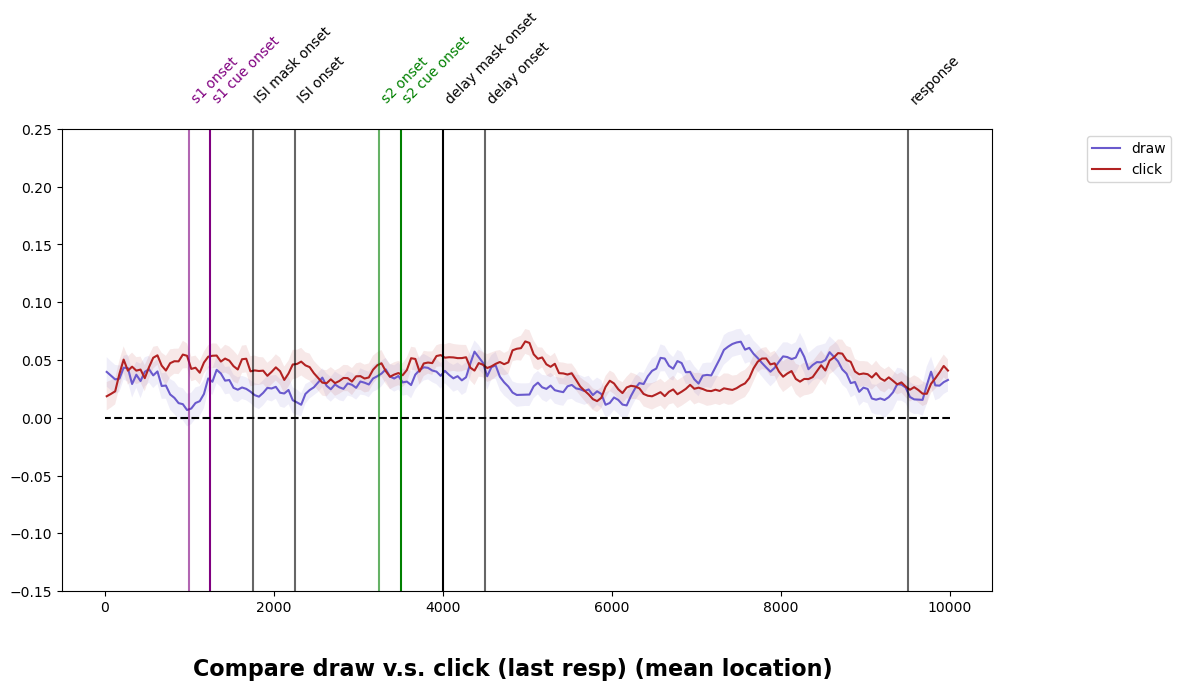

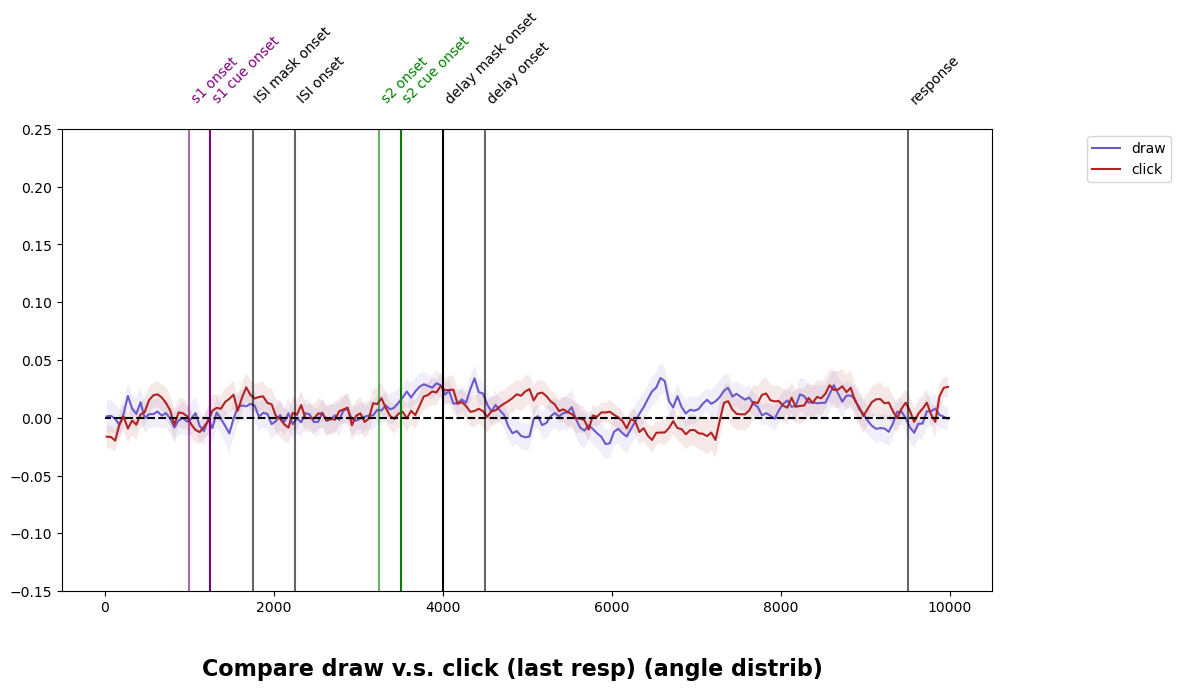

In [ ]:
mode_masks = {
    'draw': draw_lmb,
    'click': click_lmb,
}

mode_colors = {
    'draw': 'skyblue',
    'click': 'coral',
}


for feature_name in ALL_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    display_lmb_dicts_rsa(
        ax, mode_masks, ALL_FEATURE_MASKS[feature_name], 'prev_last_response', 
        ALL_FEATURE_MASK_DIST_METHODS[feature_name], colors=mode_colors)
    plt.suptitle(f'Compare draw v.s. click (last resp) ({feature_name})', y=0, fontsize=16, fontweight='bold')
    
    plot_path = os.path.join(PLOTS_FOLDER, f'last-resp_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

In [29]:
s1_cued_only = lambda df: ((df['trial_code']==0) & (df['stim_1_to_report']) & ~(df['stim_2_to_report'])).to_numpy()
both_cued_lmb = lambda df: ((df['trial_code']==0) & (df['stim_1_to_report']) & (df['stim_2_to_report'])).to_numpy()
null_cue_lmb = lambda df: (df['trial_code']==1).to_numpy()

### Analyze whether uncertainty matters


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:43,  1.24s/it]


  6%|▌         | 2/36 [00:02<00:36,  1.07s/it]


  8%|▊         | 3/36 [00:03<00:37,  1.13s/it]


 11%|█         | 4/36 [00:04<00:38,  1.22s/it]


 14%|█▍        | 5/36 [00:06<00:44,  1.45s/it]


 17%|█▋        | 6/36 [00:07<00:38,  1.29s/it]


 19%|█▉        | 7/36 [00:08<00:36,  1.26s/it]


 22%|██▏       | 8/36 [00:09<00:32,  1.16s/it]


 25%|██▌       | 9/36 [00:11<00:33,  1.22s/it]


 28%|██▊       | 10/36 [00:12<00:31,  1.22s/it]


 31%|███       | 11/36 [00:13<00:28,  1.15s/it]


 33%|███▎      | 12/36 [00:14<00:29,  1.21s/it]


 36%|███▌      | 13/36 [00:15<00:26,  1.13s/it]


 39%|███▉      | 14/36 [00:16<00:23,  1.08s/it]


 42%|████▏     | 15/36 [00:17<00:23,  1.11s/it]


 44%|████▍     | 16/36 [00:18<00:21,  1.07s/it]


 47%|████▋     | 17/36 [00:19<00:19,  1.05s/it]


 50%|█████     | 18/36 [00:20<00:19,  1.10s/it]


 53%|█████▎    | 19/36 [00:21<00:18,  1.07s/it]


 56%|█████▌    | 20/36 [00:22<00:16,  1.04s/it]


 58%|█████▊    | 21/36 [00:23<00:15,  1.02s/it]


 61%|██████    | 22/36 [00:24<00:14,  1.01s/it]


 64%|██████▍   | 23/36 [00:25<00:12,  1.01it/s]


 67%|██████▋   | 24/36 [00:26<00:11,  1.00it/s]


 69%|██████▉   | 25/36 [00:27<00:10,  1.02it/s]


 72%|███████▏  | 26/36 [00:28<00:09,  1.02it/s]


 75%|███████▌  | 27/36 [00:29<00:09,  1.04s/it]


 78%|███████▊  | 28/36 [00:30<00:08,  1.00s/it]


 81%|████████  | 29/36 [00:31<00:06,  1.01it/s]


 83%|████████▎ | 30/36 [00:32<00:05,  1.03it/s]


 86%|████████▌ | 31/36 [00:33<00:04,  1.03it/s]


 89%|████████▉ | 32/36 [00:34<00:03,  1.03it/s]


 92%|█████████▏| 33/36 [00:35<00:02,  1.02it/s]


 94%|█████████▍| 34/36 [00:36<00:01,  1.02it/s]


 97%|█████████▋| 35/36 [00:37<00:01,  1.05s/it]


100%|██████████| 36/36 [00:39<00:00,  1.09s/it]


100%|██████████| 36/36 [00:39<00:00,  1.08s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:33,  1.04it/s]


  6%|▌         | 2/36 [00:01<00:31,  1.07it/s]


  8%|▊         | 3/36 [00:02<00:31,  1.05it/s]


 11%|█         | 4/36 [00:03<00:32,  1.02s/it]


 14%|█▍        | 5/36 [00:05<00:33,  1.07s/it]


 17%|█▋        | 6/36 [00:06<00:30,  1.02s/it]


 19%|█▉        | 7/36 [00:07<00:31,  1.07s/it]


 22%|██▏       | 8/36 [00:08<00:28,  1.03s/it]


 25%|██▌       | 9/36 [00:09<00:28,  1.06s/it]


 28%|██▊       | 10/36 [00:10<00:26,  1.01s/it]


 31%|███       | 11/36 [00:11<00:24,  1.02it/s]


 33%|███▎      | 12/36 [00:12<00:23,  1.04it/s]


 36%|███▌      | 13/36 [00:12<00:21,  1.07it/s]


 39%|███▉      | 14/36 [00:14<00:21,  1.01it/s]


 42%|████▏     | 15/36 [00:14<00:20,  1.03it/s]


 44%|████▍     | 16/36 [00:16<00:20,  1.01s/it]


 47%|████▋     | 17/36 [00:16<00:18,  1.02it/s]


 50%|█████     | 18/36 [00:17<00:17,  1.04it/s]


 53%|█████▎    | 19/36 [00:19<00:17,  1.01s/it]


 56%|█████▌    | 20/36 [00:20<00:16,  1.05s/it]


 58%|█████▊    | 21/36 [00:21<00:15,  1.01s/it]


 61%|██████    | 22/36 [00:22<00:14,  1.05s/it]


 64%|██████▍   | 23/36 [00:23<00:13,  1.05s/it]


 67%|██████▋   | 24/36 [00:24<00:11,  1.00it/s]


 69%|██████▉   | 25/36 [00:25<00:11,  1.01s/it]


 72%|███████▏  | 26/36 [00:26<00:09,  1.02it/s]


 75%|███████▌  | 27/36 [00:27<00:08,  1.03it/s]


 78%|███████▊  | 28/36 [00:27<00:07,  1.05it/s]


 81%|████████  | 29/36 [00:28<00:06,  1.05it/s]


 83%|████████▎ | 30/36 [00:29<00:05,  1.05it/s]


 86%|████████▌ | 31/36 [00:31<00:05,  1.06s/it]


 89%|████████▉ | 32/36 [00:32<00:04,  1.01s/it]


 92%|█████████▏| 33/36 [00:32<00:02,  1.03it/s]


 94%|█████████▍| 34/36 [00:34<00:02,  1.08s/it]


 97%|█████████▋| 35/36 [00:35<00:01,  1.09s/it]


100%|██████████| 36/36 [00:36<00:00,  1.03s/it]


100%|██████████| 36/36 [00:36<00:00,  1.01s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:41,  1.18s/it]


  6%|▌         | 2/36 [00:02<00:39,  1.17s/it]


  8%|▊         | 3/36 [00:03<00:39,  1.19s/it]


 11%|█         | 4/36 [00:04<00:35,  1.10s/it]


 14%|█▍        | 5/36 [00:05<00:32,  1.06s/it]


 17%|█▋        | 6/36 [00:06<00:33,  1.11s/it]


 19%|█▉        | 7/36 [00:07<00:33,  1.14s/it]


 22%|██▏       | 8/36 [00:09<00:32,  1.16s/it]


 25%|██▌       | 9/36 [00:10<00:29,  1.10s/it]


 28%|██▊       | 10/36 [00:11<00:29,  1.12s/it]


 31%|███       | 11/36 [00:12<00:26,  1.07s/it]


 33%|███▎      | 12/36 [00:13<00:26,  1.09s/it]


 36%|███▌      | 13/36 [00:14<00:24,  1.05s/it]


 39%|███▉      | 14/36 [00:15<00:22,  1.03s/it]


 42%|████▏     | 15/36 [00:16<00:20,  1.01it/s]


 44%|████▍     | 16/36 [00:17<00:21,  1.05s/it]


 47%|████▋     | 17/36 [00:18<00:19,  1.03s/it]


 50%|█████     | 18/36 [00:19<00:19,  1.09s/it]


 53%|█████▎    | 19/36 [00:20<00:19,  1.12s/it]


 56%|█████▌    | 20/36 [00:21<00:18,  1.14s/it]


 58%|█████▊    | 21/36 [00:22<00:16,  1.09s/it]


 61%|██████    | 22/36 [00:24<00:16,  1.18s/it]


 64%|██████▍   | 23/36 [00:25<00:15,  1.17s/it]


 67%|██████▋   | 24/36 [00:26<00:13,  1.11s/it]


 69%|██████▉   | 25/36 [00:27<00:12,  1.11s/it]


 72%|███████▏  | 26/36 [00:29<00:12,  1.26s/it]


 75%|███████▌  | 27/36 [00:30<00:10,  1.17s/it]


 78%|███████▊  | 28/36 [00:31<00:08,  1.08s/it]


 81%|████████  | 29/36 [00:32<00:07,  1.06s/it]


 83%|████████▎ | 30/36 [00:33<00:06,  1.09s/it]


 86%|████████▌ | 31/36 [00:34<00:05,  1.05s/it]


 89%|████████▉ | 32/36 [00:35<00:04,  1.02s/it]


 92%|█████████▏| 33/36 [00:36<00:03,  1.06s/it]


 94%|█████████▍| 34/36 [00:37<00:02,  1.03s/it]


 97%|█████████▋| 35/36 [00:38<00:01,  1.07s/it]


100%|██████████| 36/36 [00:39<00:00,  1.04s/it]


100%|██████████| 36/36 [00:39<00:00,  1.09s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:33,  1.06it/s]


  6%|▌         | 2/36 [00:01<00:31,  1.07it/s]


  8%|▊         | 3/36 [00:02<00:31,  1.06it/s]


 11%|█         | 4/36 [00:03<00:29,  1.07it/s]


 14%|█▍        | 5/36 [00:04<00:29,  1.06it/s]


 17%|█▋        | 6/36 [00:05<00:28,  1.05it/s]


 19%|█▉        | 7/36 [00:06<00:27,  1.07it/s]


 22%|██▏       | 8/36 [00:07<00:25,  1.08it/s]


 25%|██▌       | 9/36 [00:08<00:24,  1.09it/s]


 28%|██▊       | 10/36 [00:09<00:24,  1.07it/s]


 31%|███       | 11/36 [00:10<00:23,  1.07it/s]


 33%|███▎      | 12/36 [00:11<00:22,  1.07it/s]


 36%|███▌      | 13/36 [00:12<00:24,  1.06s/it]


 39%|███▉      | 14/36 [00:13<00:23,  1.09s/it]


 42%|████▏     | 15/36 [00:14<00:21,  1.03s/it]


 44%|████▍     | 16/36 [00:15<00:20,  1.00s/it]


 47%|████▋     | 17/36 [00:16<00:18,  1.03it/s]


 50%|█████     | 18/36 [00:17<00:17,  1.05it/s]


 53%|█████▎    | 19/36 [00:18<00:16,  1.05it/s]


 56%|█████▌    | 20/36 [00:19<00:16,  1.01s/it]


 58%|█████▊    | 21/36 [00:20<00:14,  1.02it/s]


 61%|██████    | 22/36 [00:21<00:13,  1.04it/s]


 64%|██████▍   | 23/36 [00:22<00:12,  1.00it/s]


 67%|██████▋   | 24/36 [00:23<00:12,  1.04s/it]


 69%|██████▉   | 25/36 [00:24<00:10,  1.01it/s]


 72%|███████▏  | 26/36 [00:25<00:10,  1.04s/it]


 75%|███████▌  | 27/36 [00:26<00:09,  1.08s/it]


 78%|███████▊  | 28/36 [00:27<00:08,  1.03s/it]


 81%|████████  | 29/36 [00:28<00:07,  1.07s/it]


 83%|████████▎ | 30/36 [00:29<00:06,  1.03s/it]


 86%|████████▌ | 31/36 [00:30<00:04,  1.00it/s]


 89%|████████▉ | 32/36 [00:31<00:03,  1.03it/s]


 92%|█████████▏| 33/36 [00:32<00:03,  1.03s/it]


 94%|█████████▍| 34/36 [00:33<00:02,  1.01s/it]


 97%|█████████▋| 35/36 [00:34<00:00,  1.02it/s]


100%|██████████| 36/36 [00:35<00:00,  1.10s/it]


100%|██████████| 36/36 [00:35<00:00,  1.00it/s]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:42,  1.20s/it]


  6%|▌         | 2/36 [00:02<00:40,  1.18s/it]


  8%|▊         | 3/36 [00:03<00:42,  1.30s/it]


 11%|█         | 4/36 [00:04<00:38,  1.22s/it]


 14%|█▍        | 5/36 [00:06<00:37,  1.22s/it]


 17%|█▋        | 6/36 [00:07<00:36,  1.23s/it]


 19%|█▉        | 7/36 [00:08<00:35,  1.23s/it]


 22%|██▏       | 8/36 [00:10<00:37,  1.35s/it]


 25%|██▌       | 9/36 [00:11<00:35,  1.30s/it]


 28%|██▊       | 10/36 [00:12<00:33,  1.28s/it]


 31%|███       | 11/36 [00:13<00:31,  1.25s/it]


 33%|███▎      | 12/36 [00:14<00:29,  1.21s/it]


 36%|███▌      | 13/36 [00:16<00:27,  1.20s/it]


 39%|███▉      | 14/36 [00:17<00:26,  1.20s/it]


 42%|████▏     | 15/36 [00:18<00:27,  1.29s/it]


 44%|████▍     | 16/36 [00:20<00:26,  1.32s/it]


 47%|████▋     | 17/36 [00:21<00:24,  1.29s/it]


 50%|█████     | 18/36 [00:22<00:22,  1.26s/it]


 53%|█████▎    | 19/36 [00:24<00:22,  1.31s/it]


 56%|█████▌    | 20/36 [00:25<00:22,  1.43s/it]


 58%|█████▊    | 21/36 [00:26<00:20,  1.36s/it]


 61%|██████    | 22/36 [00:28<00:20,  1.49s/it]


 64%|██████▍   | 23/36 [00:29<00:18,  1.39s/it]


 67%|██████▋   | 24/36 [00:31<00:16,  1.34s/it]


 69%|██████▉   | 25/36 [00:32<00:13,  1.26s/it]


 72%|███████▏  | 26/36 [00:33<00:12,  1.25s/it]


 75%|███████▌  | 27/36 [00:34<00:11,  1.24s/it]


 78%|███████▊  | 28/36 [00:35<00:09,  1.24s/it]


 81%|████████  | 29/36 [00:37<00:08,  1.24s/it]


 83%|████████▎ | 30/36 [00:38<00:07,  1.20s/it]


 86%|████████▌ | 31/36 [00:39<00:06,  1.21s/it]


 89%|████████▉ | 32/36 [00:40<00:05,  1.26s/it]


 92%|█████████▏| 33/36 [00:42<00:03,  1.25s/it]


 94%|█████████▍| 34/36 [00:43<00:02,  1.29s/it]


 97%|█████████▋| 35/36 [00:44<00:01,  1.24s/it]


100%|██████████| 36/36 [00:45<00:00,  1.29s/it]


100%|██████████| 36/36 [00:45<00:00,  1.28s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:35,  1.01s/it]


  6%|▌         | 2/36 [00:02<00:34,  1.01s/it]


  8%|▊         | 3/36 [00:03<00:36,  1.12s/it]


 11%|█         | 4/36 [00:04<00:33,  1.06s/it]


 14%|█▍        | 5/36 [00:05<00:32,  1.04s/it]


 17%|█▋        | 6/36 [00:06<00:32,  1.10s/it]


 19%|█▉        | 7/36 [00:07<00:31,  1.08s/it]


 22%|██▏       | 8/36 [00:08<00:29,  1.06s/it]


 25%|██▌       | 9/36 [00:09<00:27,  1.03s/it]


 28%|██▊       | 10/36 [00:10<00:26,  1.02s/it]


 31%|███       | 11/36 [00:11<00:25,  1.02s/it]


 33%|███▎      | 12/36 [00:12<00:25,  1.07s/it]


 36%|███▌      | 13/36 [00:13<00:24,  1.08s/it]


 39%|███▉      | 14/36 [00:14<00:24,  1.11s/it]


 42%|████▏     | 15/36 [00:15<00:22,  1.07s/it]


 44%|████▍     | 16/36 [00:17<00:22,  1.11s/it]


 47%|████▋     | 17/36 [00:18<00:20,  1.07s/it]


 50%|█████     | 18/36 [00:19<00:20,  1.11s/it]


 53%|█████▎    | 19/36 [00:20<00:18,  1.07s/it]


 56%|█████▌    | 20/36 [00:21<00:16,  1.05s/it]


 58%|█████▊    | 21/36 [00:22<00:16,  1.10s/it]


 61%|██████    | 22/36 [00:23<00:15,  1.08s/it]


 64%|██████▍   | 23/36 [00:24<00:14,  1.09s/it]


 67%|██████▋   | 24/36 [00:26<00:14,  1.18s/it]


 69%|██████▉   | 25/36 [00:27<00:12,  1.13s/it]


 72%|███████▏  | 26/36 [00:28<00:11,  1.15s/it]


 75%|███████▌  | 27/36 [00:29<00:09,  1.10s/it]


 78%|███████▊  | 28/36 [00:30<00:08,  1.04s/it]


 81%|████████  | 29/36 [00:31<00:07,  1.03s/it]


 83%|████████▎ | 30/36 [00:32<00:05,  1.00it/s]


 86%|████████▌ | 31/36 [00:33<00:05,  1.04s/it]


 89%|████████▉ | 32/36 [00:34<00:04,  1.07s/it]


 92%|█████████▏| 33/36 [00:35<00:03,  1.05s/it]


 94%|█████████▍| 34/36 [00:36<00:02,  1.08s/it]


 97%|█████████▋| 35/36 [00:37<00:01,  1.05s/it]


100%|██████████| 36/36 [00:38<00:00,  1.03s/it]


100%|██████████| 36/36 [00:38<00:00,  1.07s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:50,  1.44s/it]


  6%|▌         | 2/36 [00:02<00:43,  1.29s/it]


  8%|▊         | 3/36 [00:04<00:45,  1.37s/it]


 11%|█         | 4/36 [00:05<00:42,  1.34s/it]


 14%|█▍        | 5/36 [00:06<00:39,  1.29s/it]


 17%|█▋        | 6/36 [00:07<00:37,  1.26s/it]


 19%|█▉        | 7/36 [00:09<00:38,  1.32s/it]


 22%|██▏       | 8/36 [00:10<00:35,  1.26s/it]


 25%|██▌       | 9/36 [00:11<00:33,  1.24s/it]


 28%|██▊       | 10/36 [00:12<00:32,  1.24s/it]


 31%|███       | 11/36 [00:14<00:32,  1.29s/it]


 33%|███▎      | 12/36 [00:15<00:29,  1.24s/it]


 36%|███▌      | 13/36 [00:16<00:27,  1.21s/it]


 39%|███▉      | 14/36 [00:17<00:28,  1.29s/it]


 42%|████▏     | 15/36 [00:19<00:25,  1.22s/it]


 44%|████▍     | 16/36 [00:20<00:24,  1.20s/it]


 47%|████▋     | 17/36 [00:21<00:22,  1.21s/it]


 50%|█████     | 18/36 [00:22<00:21,  1.22s/it]


 53%|█████▎    | 19/36 [00:23<00:20,  1.21s/it]


 56%|█████▌    | 20/36 [00:25<00:20,  1.27s/it]


 58%|█████▊    | 21/36 [00:26<00:18,  1.24s/it]


 61%|██████    | 22/36 [00:27<00:17,  1.22s/it]


 64%|██████▍   | 23/36 [00:28<00:15,  1.21s/it]


 67%|██████▋   | 24/36 [00:30<00:15,  1.28s/it]


 69%|██████▉   | 25/36 [00:31<00:13,  1.22s/it]


 72%|███████▏  | 26/36 [00:32<00:12,  1.22s/it]


 75%|███████▌  | 27/36 [00:33<00:11,  1.22s/it]


 78%|███████▊  | 28/36 [00:34<00:09,  1.16s/it]


 81%|████████  | 29/36 [00:36<00:08,  1.24s/it]


 83%|████████▎ | 30/36 [00:37<00:07,  1.26s/it]


 86%|████████▌ | 31/36 [00:38<00:06,  1.24s/it]


 89%|████████▉ | 32/36 [00:40<00:05,  1.29s/it]


 92%|█████████▏| 33/36 [00:41<00:03,  1.27s/it]


 94%|█████████▍| 34/36 [00:42<00:02,  1.24s/it]


 97%|█████████▋| 35/36 [00:43<00:01,  1.22s/it]


100%|██████████| 36/36 [00:44<00:00,  1.21s/it]


100%|██████████| 36/36 [00:44<00:00,  1.25s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:42,  1.20s/it]


  6%|▌         | 2/36 [00:02<00:36,  1.08s/it]


  8%|▊         | 3/36 [00:03<00:37,  1.14s/it]


 11%|█         | 4/36 [00:04<00:34,  1.07s/it]


 14%|█▍        | 5/36 [00:05<00:32,  1.05s/it]


 17%|█▋        | 6/36 [00:06<00:30,  1.03s/it]


 19%|█▉        | 7/36 [00:07<00:29,  1.03s/it]


 22%|██▏       | 8/36 [00:08<00:28,  1.03s/it]


 25%|██▌       | 9/36 [00:09<00:29,  1.08s/it]


 28%|██▊       | 10/36 [00:10<00:27,  1.06s/it]


 31%|███       | 11/36 [00:11<00:26,  1.04s/it]


 33%|███▎      | 12/36 [00:12<00:24,  1.01s/it]


 36%|███▌      | 13/36 [00:13<00:22,  1.01it/s]


 39%|███▉      | 14/36 [00:14<00:21,  1.01it/s]


 42%|████▏     | 15/36 [00:15<00:21,  1.04s/it]


 44%|████▍     | 16/36 [00:16<00:20,  1.03s/it]


 47%|████▋     | 17/36 [00:17<00:20,  1.09s/it]


 50%|█████     | 18/36 [00:18<00:19,  1.07s/it]


 53%|█████▎    | 19/36 [00:20<00:19,  1.12s/it]


 56%|█████▌    | 20/36 [00:21<00:17,  1.07s/it]


 58%|█████▊    | 21/36 [00:22<00:17,  1.17s/it]


 61%|██████    | 22/36 [00:23<00:15,  1.13s/it]


 64%|██████▍   | 23/36 [00:24<00:14,  1.12s/it]


 67%|██████▋   | 24/36 [00:25<00:13,  1.09s/it]


 69%|██████▉   | 25/36 [00:26<00:11,  1.01s/it]


 72%|███████▏  | 26/36 [00:27<00:10,  1.02s/it]


 75%|███████▌  | 27/36 [00:28<00:09,  1.03s/it]


 78%|███████▊  | 28/36 [00:29<00:08,  1.01s/it]


 81%|████████  | 29/36 [00:30<00:07,  1.02s/it]


 83%|████████▎ | 30/36 [00:31<00:06,  1.01s/it]


 86%|████████▌ | 31/36 [00:32<00:04,  1.01it/s]


 89%|████████▉ | 32/36 [00:33<00:03,  1.01it/s]


 92%|█████████▏| 33/36 [00:34<00:02,  1.00it/s]


 94%|█████████▍| 34/36 [00:35<00:01,  1.01it/s]


 97%|█████████▋| 35/36 [00:36<00:01,  1.04s/it]


100%|██████████| 36/36 [00:37<00:00,  1.03s/it]


100%|██████████| 36/36 [00:37<00:00,  1.05s/it]

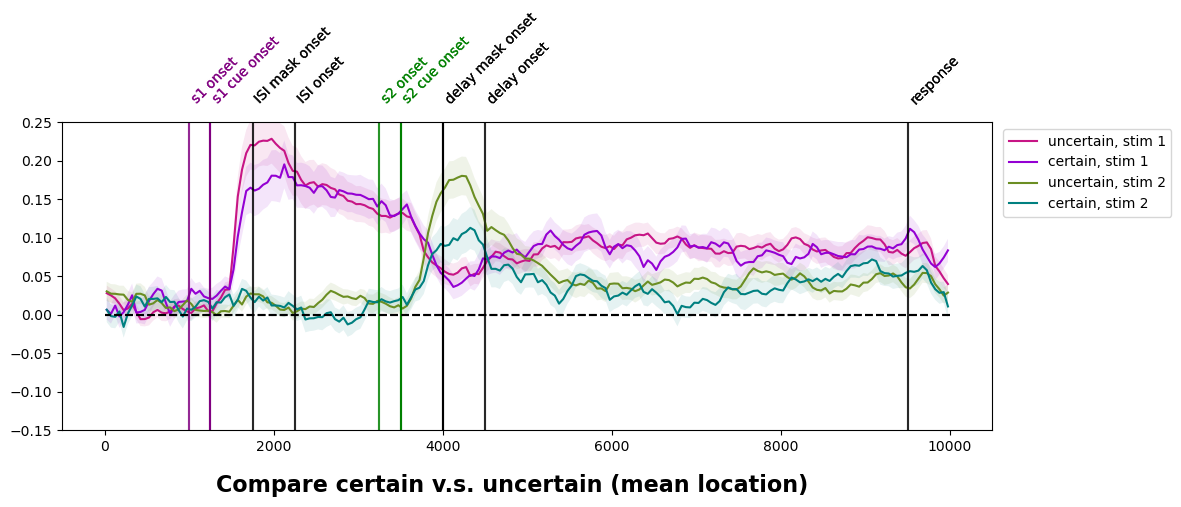

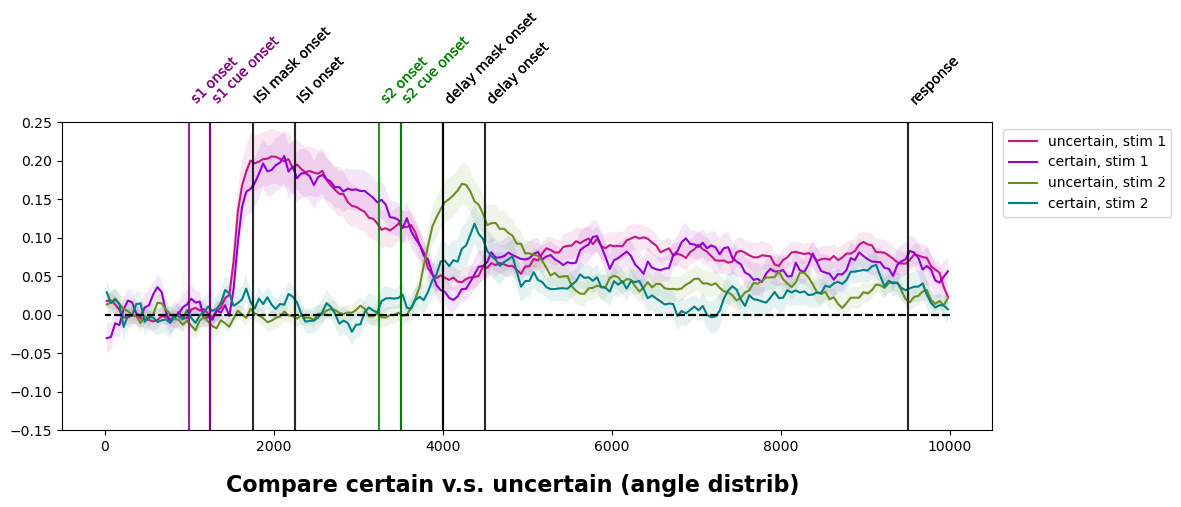

In [30]:
certainty_masks = {
    'stim_1': {
        'uncertain, stim 1': null_cue_lmb,
        'certain, stim 1': both_cued_lmb,
    },
    'stim_2': {
        'uncertain, stim 2': null_cue_lmb,
        'certain, stim 2': both_cued_lmb,
    }
}

certainty_colors = {
    'stim_1': {
        'uncertain, stim 1': 'mediumvioletred',
        'certain, stim 1': 'darkviolet',
    },
    'stim_2': {
        'uncertain, stim 2': 'olivedrab',
        'certain, stim 2': 'teal',
    }
}

for feature_name in ALL_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    to_show_legend = True
    for stim_id in ['stim_1', 'stim_2']:
        display_lmb_dicts_rsa(
            ax, certainty_masks[stim_id], ALL_FEATURE_MASKS[feature_name], stim_id, 
            ALL_FEATURE_MASK_DIST_METHODS[feature_name], colors=certainty_colors[stim_id], 
            show_legend=to_show_legend)
    plt.suptitle(f'Compare certain v.s. uncertain ({feature_name})', y=0, fontsize=16, fontweight='bold')
    plot_path = os.path.join(PLOTS_FOLDER, f'certainty_stim_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:53,  1.53s/it]


  6%|▌         | 2/36 [00:02<00:44,  1.30s/it]


  8%|▊         | 3/36 [00:03<00:37,  1.15s/it]


 11%|█         | 4/36 [00:04<00:36,  1.14s/it]


 14%|█▍        | 5/36 [00:05<00:33,  1.07s/it]


 17%|█▋        | 6/36 [00:06<00:32,  1.09s/it]


 19%|█▉        | 7/36 [00:07<00:32,  1.11s/it]


 22%|██▏       | 8/36 [00:08<00:29,  1.05s/it]


 25%|██▌       | 9/36 [00:09<00:27,  1.01s/it]


 28%|██▊       | 10/36 [00:10<00:27,  1.05s/it]


 31%|███       | 11/36 [00:12<00:28,  1.14s/it]


 33%|███▎      | 12/36 [00:13<00:28,  1.19s/it]


 36%|███▌      | 13/36 [00:15<00:28,  1.25s/it]


 39%|███▉      | 14/36 [00:15<00:25,  1.16s/it]


 42%|████▏     | 15/36 [00:17<00:23,  1.14s/it]


 44%|████▍     | 16/36 [00:18<00:24,  1.24s/it]


 47%|████▋     | 17/36 [00:19<00:22,  1.21s/it]


 50%|█████     | 18/36 [00:20<00:21,  1.19s/it]


 53%|█████▎    | 19/36 [00:21<00:19,  1.16s/it]


 56%|█████▌    | 20/36 [00:22<00:17,  1.09s/it]


 58%|█████▊    | 21/36 [00:23<00:15,  1.04s/it]


 61%|██████    | 22/36 [00:24<00:14,  1.01s/it]


 64%|██████▍   | 23/36 [00:25<00:12,  1.01it/s]


 67%|██████▋   | 24/36 [00:26<00:11,  1.04it/s]


 69%|██████▉   | 25/36 [00:27<00:10,  1.09it/s]


 72%|███████▏  | 26/36 [00:28<00:09,  1.09it/s]


 75%|███████▌  | 27/36 [00:29<00:08,  1.07it/s]


 78%|███████▊  | 28/36 [00:30<00:07,  1.03it/s]


 81%|████████  | 29/36 [00:31<00:06,  1.07it/s]


 83%|████████▎ | 30/36 [00:32<00:05,  1.09it/s]


 86%|████████▌ | 31/36 [00:32<00:04,  1.09it/s]


 89%|████████▉ | 32/36 [00:33<00:03,  1.08it/s]


 92%|█████████▏| 33/36 [00:34<00:02,  1.08it/s]


 94%|█████████▍| 34/36 [00:35<00:01,  1.08it/s]


 97%|█████████▋| 35/36 [00:36<00:00,  1.09it/s]


100%|██████████| 36/36 [00:37<00:00,  1.10it/s]


100%|██████████| 36/36 [00:37<00:00,  1.04s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:31,  1.10it/s]


  6%|▌         | 2/36 [00:02<00:41,  1.22s/it]


  8%|▊         | 3/36 [00:03<00:35,  1.08s/it]


 11%|█         | 4/36 [00:04<00:34,  1.09s/it]


 14%|█▍        | 5/36 [00:05<00:31,  1.02s/it]


 17%|█▋        | 6/36 [00:06<00:29,  1.03it/s]


 19%|█▉        | 7/36 [00:07<00:27,  1.05it/s]


 22%|██▏       | 8/36 [00:07<00:26,  1.05it/s]


 25%|██▌       | 9/36 [00:08<00:25,  1.07it/s]


 28%|██▊       | 10/36 [00:10<00:26,  1.00s/it]


 31%|███       | 11/36 [00:11<00:24,  1.01it/s]


 33%|███▎      | 12/36 [00:11<00:23,  1.04it/s]


 36%|███▌      | 13/36 [00:12<00:21,  1.06it/s]


 39%|███▉      | 14/36 [00:13<00:20,  1.08it/s]


 42%|████▏     | 15/36 [00:14<00:19,  1.09it/s]


 44%|████▍     | 16/36 [00:15<00:18,  1.09it/s]


 47%|████▋     | 17/36 [00:16<00:17,  1.08it/s]


 50%|█████     | 18/36 [00:17<00:16,  1.09it/s]


 53%|█████▎    | 19/36 [00:18<00:15,  1.09it/s]


 56%|█████▌    | 20/36 [00:19<00:14,  1.10it/s]


 58%|█████▊    | 21/36 [00:20<00:13,  1.08it/s]


 61%|██████    | 22/36 [00:21<00:14,  1.00s/it]


 64%|██████▍   | 23/36 [00:22<00:13,  1.04s/it]


 67%|██████▋   | 24/36 [00:23<00:12,  1.01s/it]


 69%|██████▉   | 25/36 [00:24<00:10,  1.04it/s]


 72%|███████▏  | 26/36 [00:25<00:09,  1.03it/s]


 75%|███████▌  | 27/36 [00:26<00:09,  1.03s/it]


 78%|███████▊  | 28/36 [00:27<00:07,  1.01it/s]


 81%|████████  | 29/36 [00:28<00:06,  1.03it/s]


 83%|████████▎ | 30/36 [00:29<00:06,  1.00s/it]


 86%|████████▌ | 31/36 [00:30<00:04,  1.04it/s]


 89%|████████▉ | 32/36 [00:31<00:04,  1.04s/it]


 92%|█████████▏| 33/36 [00:32<00:02,  1.00it/s]


 94%|█████████▍| 34/36 [00:33<00:01,  1.02it/s]


 97%|█████████▋| 35/36 [00:34<00:00,  1.03it/s]


100%|██████████| 36/36 [00:35<00:00,  1.04it/s]


100%|██████████| 36/36 [00:35<00:00,  1.03it/s]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:38,  1.11s/it]


  6%|▌         | 2/36 [00:02<00:34,  1.02s/it]


  8%|▊         | 3/36 [00:03<00:32,  1.02it/s]


 11%|█         | 4/36 [00:04<00:35,  1.12s/it]


 14%|█▍        | 5/36 [00:05<00:32,  1.06s/it]


 17%|█▋        | 6/36 [00:06<00:32,  1.09s/it]


 19%|█▉        | 7/36 [00:07<00:30,  1.04s/it]


 22%|██▏       | 8/36 [00:08<00:30,  1.07s/it]


 25%|██▌       | 9/36 [00:09<00:27,  1.02s/it]


 28%|██▊       | 10/36 [00:10<00:25,  1.00it/s]


 31%|███       | 11/36 [00:11<00:24,  1.02it/s]


 33%|███▎      | 12/36 [00:12<00:23,  1.04it/s]


 36%|███▌      | 13/36 [00:13<00:21,  1.05it/s]


 39%|███▉      | 14/36 [00:14<00:20,  1.06it/s]


 42%|████▏     | 15/36 [00:14<00:19,  1.07it/s]


 44%|████▍     | 16/36 [00:15<00:18,  1.07it/s]


 47%|████▋     | 17/36 [00:16<00:17,  1.07it/s]


 50%|█████     | 18/36 [00:17<00:16,  1.09it/s]


 53%|█████▎    | 19/36 [00:18<00:16,  1.02it/s]


 56%|█████▌    | 20/36 [00:19<00:15,  1.04it/s]


 58%|█████▊    | 21/36 [00:20<00:14,  1.07it/s]


 61%|██████    | 22/36 [00:21<00:12,  1.08it/s]


 64%|██████▍   | 23/36 [00:22<00:12,  1.01it/s]


 67%|██████▋   | 24/36 [00:24<00:13,  1.11s/it]


 69%|██████▉   | 25/36 [00:24<00:11,  1.04s/it]


 72%|███████▏  | 26/36 [00:25<00:10,  1.01s/it]


 75%|███████▌  | 27/36 [00:26<00:08,  1.01it/s]


 78%|███████▊  | 28/36 [00:27<00:08,  1.02s/it]


 81%|████████  | 29/36 [00:28<00:06,  1.01it/s]


 83%|████████▎ | 30/36 [00:29<00:05,  1.04it/s]


 86%|████████▌ | 31/36 [00:30<00:04,  1.04it/s]


 89%|████████▉ | 32/36 [00:31<00:03,  1.05it/s]


 92%|█████████▏| 33/36 [00:32<00:02,  1.06it/s]


 94%|█████████▍| 34/36 [00:33<00:01,  1.06it/s]


 97%|█████████▋| 35/36 [00:34<00:00,  1.06it/s]


100%|██████████| 36/36 [00:35<00:00,  1.07it/s]


100%|██████████| 36/36 [00:35<00:00,  1.02it/s]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:32,  1.08it/s]


  6%|▌         | 2/36 [00:01<00:31,  1.08it/s]


  8%|▊         | 3/36 [00:02<00:30,  1.07it/s]


 11%|█         | 4/36 [00:03<00:29,  1.08it/s]


 14%|█▍        | 5/36 [00:04<00:28,  1.08it/s]


 17%|█▋        | 6/36 [00:05<00:30,  1.01s/it]


 19%|█▉        | 7/36 [00:06<00:28,  1.02it/s]


 22%|██▏       | 8/36 [00:07<00:26,  1.05it/s]


 25%|██▌       | 9/36 [00:08<00:25,  1.07it/s]


 28%|██▊       | 10/36 [00:09<00:24,  1.07it/s]


 31%|███       | 11/36 [00:10<00:23,  1.07it/s]


 33%|███▎      | 12/36 [00:11<00:22,  1.09it/s]


 36%|███▌      | 13/36 [00:12<00:21,  1.08it/s]


 39%|███▉      | 14/36 [00:13<00:20,  1.08it/s]


 42%|████▏     | 15/36 [00:14<00:19,  1.09it/s]


 44%|████▍     | 16/36 [00:14<00:18,  1.08it/s]


 47%|████▋     | 17/36 [00:15<00:17,  1.07it/s]


 50%|█████     | 18/36 [00:16<00:16,  1.07it/s]


 53%|█████▎    | 19/36 [00:17<00:15,  1.07it/s]


 56%|█████▌    | 20/36 [00:18<00:14,  1.07it/s]


 58%|█████▊    | 21/36 [00:19<00:14,  1.07it/s]


 61%|██████    | 22/36 [00:20<00:13,  1.07it/s]


 64%|██████▍   | 23/36 [00:21<00:13,  1.01s/it]


 67%|██████▋   | 24/36 [00:22<00:12,  1.04s/it]


 69%|██████▉   | 25/36 [00:23<00:10,  1.02it/s]


 72%|███████▏  | 26/36 [00:24<00:09,  1.03it/s]


 75%|███████▌  | 27/36 [00:25<00:08,  1.04it/s]


 78%|███████▊  | 28/36 [00:26<00:07,  1.08it/s]


 81%|████████  | 29/36 [00:27<00:06,  1.07it/s]


 83%|████████▎ | 30/36 [00:28<00:05,  1.07it/s]


 86%|████████▌ | 31/36 [00:29<00:04,  1.08it/s]


 89%|████████▉ | 32/36 [00:30<00:03,  1.07it/s]


 92%|█████████▏| 33/36 [00:31<00:02,  1.08it/s]


 94%|█████████▍| 34/36 [00:32<00:01,  1.07it/s]


 97%|█████████▋| 35/36 [00:33<00:01,  1.00s/it]


100%|██████████| 36/36 [00:34<00:00,  1.02it/s]


100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:35,  1.02s/it]


  6%|▌         | 2/36 [00:02<00:35,  1.04s/it]


  8%|▊         | 3/36 [00:03<00:35,  1.07s/it]


 11%|█         | 4/36 [00:04<00:33,  1.05s/it]


 14%|█▍        | 5/36 [00:05<00:32,  1.05s/it]


 17%|█▋        | 6/36 [00:06<00:33,  1.13s/it]


 19%|█▉        | 7/36 [00:07<00:31,  1.10s/it]


 22%|██▏       | 8/36 [00:08<00:30,  1.09s/it]


 25%|██▌       | 9/36 [00:09<00:29,  1.09s/it]


 28%|██▊       | 10/36 [00:10<00:27,  1.07s/it]


 31%|███       | 11/36 [00:11<00:26,  1.07s/it]


 33%|███▎      | 12/36 [00:13<00:26,  1.12s/it]


 36%|███▌      | 13/36 [00:14<00:25,  1.10s/it]


 39%|███▉      | 14/36 [00:15<00:25,  1.16s/it]


 42%|████▏     | 15/36 [00:16<00:23,  1.10s/it]


 44%|████▍     | 16/36 [00:17<00:22,  1.11s/it]


 47%|████▋     | 17/36 [00:18<00:20,  1.10s/it]


 50%|█████     | 18/36 [00:19<00:19,  1.09s/it]


 53%|█████▎    | 19/36 [00:20<00:19,  1.12s/it]


 56%|█████▌    | 20/36 [00:21<00:17,  1.10s/it]


 58%|█████▊    | 21/36 [00:22<00:16,  1.08s/it]


 61%|██████    | 22/36 [00:23<00:15,  1.08s/it]


 64%|██████▍   | 23/36 [00:25<00:13,  1.07s/it]


 67%|██████▋   | 24/36 [00:26<00:13,  1.12s/it]


 69%|██████▉   | 25/36 [00:27<00:12,  1.10s/it]


 72%|███████▏  | 26/36 [00:28<00:10,  1.08s/it]


 75%|███████▌  | 27/36 [00:29<00:09,  1.08s/it]


 78%|███████▊  | 28/36 [00:30<00:08,  1.06s/it]


 81%|████████  | 29/36 [00:31<00:07,  1.11s/it]


 83%|████████▎ | 30/36 [00:32<00:06,  1.07s/it]


 86%|████████▌ | 31/36 [00:33<00:05,  1.08s/it]


 89%|████████▉ | 32/36 [00:34<00:04,  1.07s/it]


 92%|█████████▏| 33/36 [00:35<00:03,  1.06s/it]


 94%|█████████▍| 34/36 [00:36<00:02,  1.07s/it]


 97%|█████████▋| 35/36 [00:37<00:01,  1.06s/it]


100%|██████████| 36/36 [00:38<00:00,  1.04s/it]


100%|██████████| 36/36 [00:38<00:00,  1.08s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:51,  1.46s/it]


  6%|▌         | 2/36 [00:02<00:44,  1.31s/it]


  8%|▊         | 3/36 [00:03<00:39,  1.19s/it]


 11%|█         | 4/36 [00:04<00:34,  1.09s/it]


 14%|█▍        | 5/36 [00:05<00:32,  1.05s/it]


 17%|█▋        | 6/36 [00:06<00:30,  1.03s/it]


 19%|█▉        | 7/36 [00:07<00:29,  1.01s/it]


 22%|██▏       | 8/36 [00:08<00:28,  1.02s/it]


 25%|██▌       | 9/36 [00:09<00:28,  1.06s/it]


 28%|██▊       | 10/36 [00:10<00:27,  1.05s/it]


 31%|███       | 11/36 [00:11<00:26,  1.05s/it]


 33%|███▎      | 12/36 [00:13<00:27,  1.15s/it]


 36%|███▌      | 13/36 [00:14<00:25,  1.10s/it]


 39%|███▉      | 14/36 [00:15<00:23,  1.08s/it]


 42%|████▏     | 15/36 [00:16<00:21,  1.04s/it]


 44%|████▍     | 16/36 [00:17<00:20,  1.03s/it]


 47%|████▋     | 17/36 [00:18<00:19,  1.02s/it]


 50%|█████     | 18/36 [00:19<00:18,  1.02s/it]


 53%|█████▎    | 19/36 [00:20<00:17,  1.02s/it]


 56%|█████▌    | 20/36 [00:21<00:17,  1.07s/it]


 58%|█████▊    | 21/36 [00:22<00:15,  1.06s/it]


 61%|██████    | 22/36 [00:23<00:14,  1.05s/it]


 64%|██████▍   | 23/36 [00:24<00:13,  1.02s/it]


 67%|██████▋   | 24/36 [00:25<00:12,  1.02s/it]


 69%|██████▉   | 25/36 [00:26<00:11,  1.03s/it]


 72%|███████▏  | 26/36 [00:27<00:10,  1.04s/it]


 75%|███████▌  | 27/36 [00:28<00:09,  1.08s/it]


 78%|███████▊  | 28/36 [00:29<00:08,  1.03s/it]


 81%|████████  | 29/36 [00:30<00:07,  1.04s/it]


 83%|████████▎ | 30/36 [00:31<00:06,  1.01s/it]


 86%|████████▌ | 31/36 [00:32<00:04,  1.02it/s]


 89%|████████▉ | 32/36 [00:33<00:03,  1.01it/s]


 92%|█████████▏| 33/36 [00:34<00:03,  1.06s/it]


 94%|█████████▍| 34/36 [00:35<00:02,  1.05s/it]


 97%|█████████▋| 35/36 [00:36<00:01,  1.04s/it]


100%|██████████| 36/36 [00:37<00:00,  1.03s/it]


100%|██████████| 36/36 [00:37<00:00,  1.05s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:38,  1.10s/it]


  6%|▌         | 2/36 [00:02<00:41,  1.22s/it]


  8%|▊         | 3/36 [00:03<00:37,  1.14s/it]


 11%|█         | 4/36 [00:04<00:34,  1.08s/it]


 14%|█▍        | 5/36 [00:05<00:33,  1.09s/it]


 17%|█▋        | 6/36 [00:06<00:32,  1.09s/it]


 19%|█▉        | 7/36 [00:07<00:31,  1.09s/it]


 22%|██▏       | 8/36 [00:08<00:31,  1.14s/it]


 25%|██▌       | 9/36 [00:10<00:31,  1.17s/it]


 28%|██▊       | 10/36 [00:11<00:29,  1.15s/it]


 31%|███       | 11/36 [00:12<00:28,  1.13s/it]


 33%|███▎      | 12/36 [00:13<00:29,  1.22s/it]


 36%|███▌      | 13/36 [00:14<00:27,  1.18s/it]


 39%|███▉      | 14/36 [00:16<00:27,  1.26s/it]


 42%|████▏     | 15/36 [00:17<00:24,  1.18s/it]


 44%|████▍     | 16/36 [00:18<00:23,  1.15s/it]


 47%|████▋     | 17/36 [00:19<00:22,  1.19s/it]


 50%|█████     | 18/36 [00:20<00:20,  1.16s/it]


 53%|█████▎    | 19/36 [00:22<00:20,  1.20s/it]


 56%|█████▌    | 20/36 [00:23<00:19,  1.22s/it]


 58%|█████▊    | 21/36 [00:24<00:18,  1.22s/it]


 61%|██████    | 22/36 [00:26<00:18,  1.30s/it]


 64%|██████▍   | 23/36 [00:27<00:16,  1.23s/it]


 67%|██████▋   | 24/36 [00:28<00:14,  1.19s/it]


 69%|██████▉   | 25/36 [00:29<00:12,  1.13s/it]


 72%|███████▏  | 26/36 [00:30<00:11,  1.19s/it]


 75%|███████▌  | 27/36 [00:32<00:11,  1.30s/it]


 78%|███████▊  | 28/36 [00:33<00:10,  1.27s/it]


 81%|████████  | 29/36 [00:34<00:08,  1.28s/it]


 83%|████████▎ | 30/36 [00:35<00:07,  1.27s/it]


 86%|████████▌ | 31/36 [00:37<00:06,  1.28s/it]


 89%|████████▉ | 32/36 [00:38<00:04,  1.23s/it]


 92%|█████████▏| 33/36 [00:39<00:03,  1.18s/it]


 94%|█████████▍| 34/36 [00:40<00:02,  1.15s/it]


 97%|█████████▋| 35/36 [00:41<00:01,  1.27s/it]


100%|██████████| 36/36 [00:42<00:00,  1.18s/it]


100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:34,  1.00it/s]


  6%|▌         | 2/36 [00:02<00:37,  1.12s/it]


  8%|▊         | 3/36 [00:03<00:38,  1.18s/it]


 11%|█         | 4/36 [00:04<00:34,  1.08s/it]


 14%|█▍        | 5/36 [00:05<00:37,  1.20s/it]


 17%|█▋        | 6/36 [00:07<00:36,  1.21s/it]


 19%|█▉        | 7/36 [00:09<00:45,  1.56s/it]


 22%|██▏       | 8/36 [00:10<00:42,  1.52s/it]


 25%|██▌       | 9/36 [00:12<00:41,  1.55s/it]


 28%|██▊       | 10/36 [00:14<00:41,  1.60s/it]


 31%|███       | 11/36 [00:15<00:35,  1.42s/it]


 33%|███▎      | 12/36 [00:16<00:32,  1.36s/it]


 36%|███▌      | 13/36 [00:17<00:29,  1.30s/it]


 39%|███▉      | 14/36 [00:18<00:28,  1.28s/it]


 42%|████▏     | 15/36 [00:19<00:26,  1.26s/it]


 44%|████▍     | 16/36 [00:21<00:25,  1.29s/it]


 47%|████▋     | 17/36 [00:22<00:24,  1.27s/it]


 50%|█████     | 18/36 [00:23<00:22,  1.25s/it]


 53%|█████▎    | 19/36 [00:24<00:20,  1.18s/it]


 56%|█████▌    | 20/36 [00:25<00:17,  1.12s/it]


 58%|█████▊    | 21/36 [00:26<00:16,  1.09s/it]


 61%|██████    | 22/36 [00:27<00:14,  1.06s/it]


 64%|██████▍   | 23/36 [00:28<00:13,  1.02s/it]


 67%|██████▋   | 24/36 [00:29<00:12,  1.00s/it]


 69%|██████▉   | 25/36 [00:30<00:10,  1.04it/s]


 72%|███████▏  | 26/36 [00:31<00:09,  1.02it/s]


 75%|███████▌  | 27/36 [00:32<00:08,  1.01it/s]


 78%|███████▊  | 28/36 [00:33<00:08,  1.03s/it]


 81%|████████  | 29/36 [00:34<00:07,  1.08s/it]


 83%|████████▎ | 30/36 [00:35<00:06,  1.05s/it]


 86%|████████▌ | 31/36 [00:36<00:05,  1.03s/it]


 89%|████████▉ | 32/36 [00:37<00:04,  1.02s/it]


 92%|█████████▏| 33/36 [00:38<00:03,  1.01s/it]


 94%|█████████▍| 34/36 [00:39<00:02,  1.02s/it]


 97%|█████████▋| 35/36 [00:41<00:01,  1.12s/it]


100%|██████████| 36/36 [00:42<00:00,  1.07s/it]


100%|██████████| 36/36 [00:42<00:00,  1.17s/it]

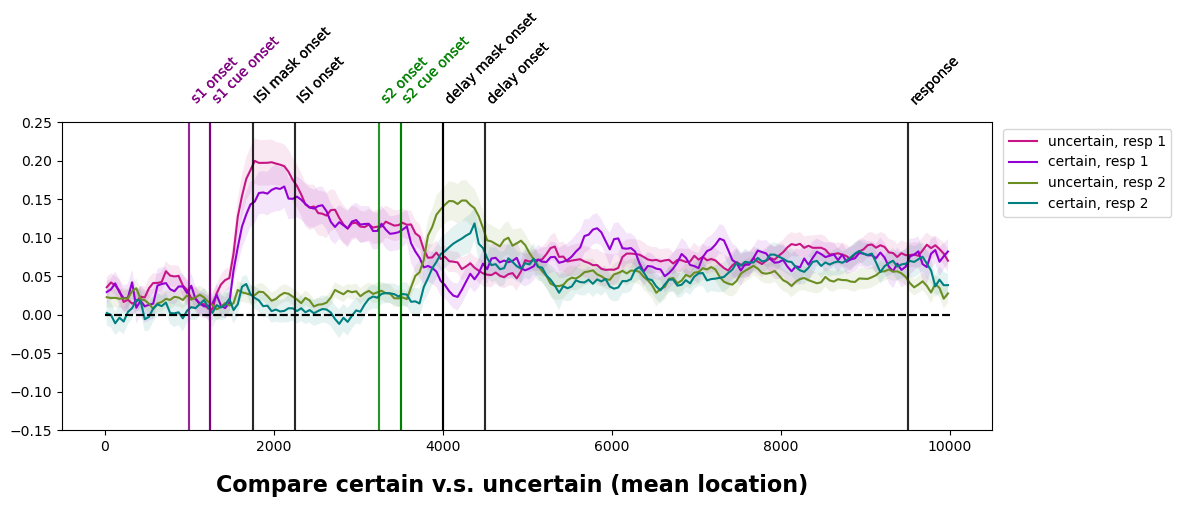

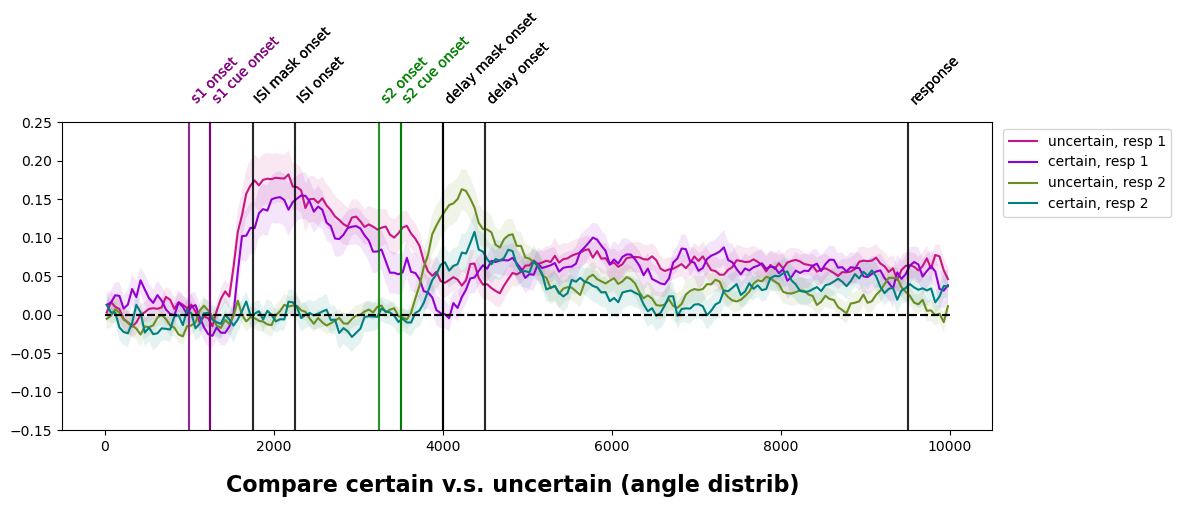

In [31]:
certainty_masks = {
    'resp_1': {
        'uncertain, resp 1': null_cue_lmb,
        'certain, resp 1': both_cued_lmb,
    },
    'resp_2': {
        'uncertain, resp 2': null_cue_lmb,
        'certain, resp 2': both_cued_lmb,
    }
}

certainty_colors = {
    'resp_1': {
        'uncertain, resp 1': 'mediumvioletred',
        'certain, resp 1': 'darkviolet',
    },
    'resp_2': {
        'uncertain, resp 2': 'olivedrab',
        'certain, resp 2': 'teal',
    }
}

for feature_name in ALL_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    to_show_legend = True
    for stim_id in ['resp_1', 'resp_2']:
        display_lmb_dicts_rsa(
            ax, certainty_masks[stim_id], ALL_FEATURE_MASKS[feature_name], stim_id, 
            ALL_FEATURE_MASK_DIST_METHODS[feature_name], colors=certainty_colors[stim_id], 
            show_legend=to_show_legend)
    plt.suptitle(f'Compare certain v.s. uncertain ({feature_name})', y=0, fontsize=16, fontweight='bold')
    plot_path = os.path.join(PLOTS_FOLDER, f'certainty_resp_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:49,  1.40s/it]


  6%|▌         | 2/36 [00:02<00:42,  1.26s/it]


  8%|▊         | 3/36 [00:03<00:36,  1.12s/it]


 11%|█         | 4/36 [00:04<00:35,  1.12s/it]


 14%|█▍        | 5/36 [00:05<00:32,  1.06s/it]


 17%|█▋        | 6/36 [00:06<00:32,  1.10s/it]


 19%|█▉        | 7/36 [00:07<00:30,  1.05s/it]


 22%|██▏       | 8/36 [00:08<00:30,  1.09s/it]


 25%|██▌       | 9/36 [00:09<00:28,  1.04s/it]


 28%|██▊       | 10/36 [00:10<00:26,  1.02s/it]


 31%|███       | 11/36 [00:11<00:25,  1.00s/it]


 33%|███▎      | 12/36 [00:12<00:23,  1.01it/s]


 36%|███▌      | 13/36 [00:13<00:22,  1.03it/s]


 39%|███▉      | 14/36 [00:14<00:21,  1.03it/s]


 42%|████▏     | 15/36 [00:15<00:20,  1.05it/s]


 44%|████▍     | 16/36 [00:16<00:18,  1.07it/s]


 47%|████▋     | 17/36 [00:17<00:17,  1.07it/s]


 50%|█████     | 18/36 [00:18<00:16,  1.06it/s]


 53%|█████▎    | 19/36 [00:19<00:16,  1.06it/s]


 56%|█████▌    | 20/36 [00:20<00:17,  1.07s/it]


 58%|█████▊    | 21/36 [00:21<00:15,  1.04s/it]


 61%|██████    | 22/36 [00:22<00:15,  1.07s/it]


 64%|██████▍   | 23/36 [00:23<00:13,  1.03s/it]


 67%|██████▋   | 24/36 [00:24<00:12,  1.00s/it]


 69%|██████▉   | 25/36 [00:25<00:10,  1.04it/s]


 72%|███████▏  | 26/36 [00:26<00:09,  1.04it/s]


 75%|███████▌  | 27/36 [00:27<00:08,  1.05it/s]


 78%|███████▊  | 28/36 [00:28<00:07,  1.09it/s]


 81%|████████  | 29/36 [00:29<00:06,  1.08it/s]


 83%|████████▎ | 30/36 [00:30<00:05,  1.01it/s]


 86%|████████▌ | 31/36 [00:31<00:04,  1.02it/s]


 89%|████████▉ | 32/36 [00:32<00:03,  1.03it/s]


 92%|█████████▏| 33/36 [00:33<00:02,  1.03it/s]


 94%|█████████▍| 34/36 [00:34<00:02,  1.02s/it]


 97%|█████████▋| 35/36 [00:35<00:01,  1.00s/it]


100%|██████████| 36/36 [00:36<00:00,  1.03it/s]


100%|██████████| 36/36 [00:36<00:00,  1.00s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:30,  1.15it/s]


  6%|▌         | 2/36 [00:01<00:29,  1.14it/s]


  8%|▊         | 3/36 [00:02<00:32,  1.01it/s]


 11%|█         | 4/36 [00:03<00:30,  1.05it/s]


 14%|█▍        | 5/36 [00:04<00:31,  1.00s/it]


 17%|█▋        | 6/36 [00:05<00:31,  1.04s/it]


 19%|█▉        | 7/36 [00:06<00:29,  1.01s/it]


 22%|██▏       | 8/36 [00:07<00:27,  1.02it/s]


 25%|██▌       | 9/36 [00:08<00:25,  1.05it/s]


 28%|██▊       | 10/36 [00:09<00:24,  1.07it/s]


 31%|███       | 11/36 [00:10<00:26,  1.05s/it]


 33%|███▎      | 12/36 [00:12<00:25,  1.05s/it]


 36%|███▌      | 13/36 [00:13<00:24,  1.06s/it]


 39%|███▉      | 14/36 [00:13<00:22,  1.00s/it]


 42%|████▏     | 15/36 [00:15<00:21,  1.02s/it]


 44%|████▍     | 16/36 [00:15<00:19,  1.02it/s]


 47%|████▋     | 17/36 [00:16<00:18,  1.04it/s]


 50%|█████     | 18/36 [00:17<00:17,  1.06it/s]


 53%|█████▎    | 19/36 [00:18<00:15,  1.07it/s]


 56%|█████▌    | 20/36 [00:19<00:14,  1.08it/s]


 58%|█████▊    | 21/36 [00:20<00:13,  1.08it/s]


 61%|██████    | 22/36 [00:21<00:13,  1.00it/s]


 64%|██████▍   | 23/36 [00:22<00:12,  1.04it/s]


 67%|██████▋   | 24/36 [00:23<00:11,  1.06it/s]


 69%|██████▉   | 25/36 [00:24<00:11,  1.03s/it]


 72%|███████▏  | 26/36 [00:25<00:09,  1.02it/s]


 75%|███████▌  | 27/36 [00:26<00:08,  1.06it/s]


 78%|███████▊  | 28/36 [00:27<00:07,  1.11it/s]


 81%|████████  | 29/36 [00:28<00:06,  1.05it/s]


 83%|████████▎ | 30/36 [00:29<00:05,  1.07it/s]


 86%|████████▌ | 31/36 [00:30<00:04,  1.08it/s]


 89%|████████▉ | 32/36 [00:30<00:03,  1.09it/s]


 92%|█████████▏| 33/36 [00:31<00:02,  1.09it/s]


 94%|█████████▍| 34/36 [00:32<00:01,  1.09it/s]


 97%|█████████▋| 35/36 [00:33<00:00,  1.10it/s]


100%|██████████| 36/36 [00:34<00:00,  1.10it/s]


100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:38,  1.09s/it]


  6%|▌         | 2/36 [00:02<00:41,  1.23s/it]


  8%|▊         | 3/36 [00:03<00:40,  1.23s/it]


 11%|█         | 4/36 [00:04<00:39,  1.24s/it]


 14%|█▍        | 5/36 [00:06<00:36,  1.19s/it]


 17%|█▋        | 6/36 [00:07<00:35,  1.17s/it]


 19%|█▉        | 7/36 [00:08<00:35,  1.23s/it]


 22%|██▏       | 8/36 [00:09<00:33,  1.20s/it]


 25%|██▌       | 9/36 [00:10<00:31,  1.18s/it]


 28%|██▊       | 10/36 [00:11<00:30,  1.17s/it]


 31%|███       | 11/36 [00:13<00:29,  1.16s/it]


 33%|███▎      | 12/36 [00:14<00:30,  1.25s/it]


 36%|███▌      | 13/36 [00:15<00:27,  1.20s/it]


 39%|███▉      | 14/36 [00:16<00:26,  1.18s/it]


 42%|████▏     | 15/36 [00:17<00:23,  1.13s/it]


 44%|████▍     | 16/36 [00:18<00:22,  1.13s/it]


 47%|████▋     | 17/36 [00:20<00:21,  1.14s/it]


 50%|█████     | 18/36 [00:21<00:20,  1.14s/it]


 53%|█████▎    | 19/36 [00:22<00:20,  1.20s/it]


 56%|█████▌    | 20/36 [00:23<00:18,  1.17s/it]


 58%|█████▊    | 21/36 [00:24<00:18,  1.21s/it]


 61%|██████    | 22/36 [00:25<00:16,  1.16s/it]


 64%|██████▍   | 23/36 [00:27<00:14,  1.13s/it]


 67%|██████▋   | 24/36 [00:28<00:13,  1.12s/it]


 69%|██████▉   | 25/36 [00:29<00:12,  1.10s/it]


 72%|███████▏  | 26/36 [00:30<00:11,  1.10s/it]


 75%|███████▌  | 27/36 [00:31<00:10,  1.12s/it]


 78%|███████▊  | 28/36 [00:32<00:08,  1.08s/it]


 81%|████████  | 29/36 [00:33<00:07,  1.10s/it]


 83%|████████▎ | 30/36 [00:34<00:06,  1.09s/it]


 86%|████████▌ | 31/36 [00:35<00:05,  1.17s/it]


 89%|████████▉ | 32/36 [00:37<00:04,  1.16s/it]


 92%|█████████▏| 33/36 [00:38<00:03,  1.27s/it]


 94%|█████████▍| 34/36 [00:39<00:02,  1.22s/it]


 97%|█████████▋| 35/36 [00:40<00:01,  1.18s/it]


100%|██████████| 36/36 [00:41<00:00,  1.14s/it]


100%|██████████| 36/36 [00:41<00:00,  1.16s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:34,  1.00it/s]


  6%|▌         | 2/36 [00:01<00:33,  1.02it/s]


  8%|▊         | 3/36 [00:02<00:32,  1.00it/s]


 11%|█         | 4/36 [00:03<00:31,  1.02it/s]


 14%|█▍        | 5/36 [00:04<00:30,  1.01it/s]


 17%|█▋        | 6/36 [00:05<00:29,  1.01it/s]


 19%|█▉        | 7/36 [00:07<00:31,  1.07s/it]


 22%|██▏       | 8/36 [00:08<00:29,  1.05s/it]


 25%|██▌       | 9/36 [00:09<00:27,  1.02s/it]


 28%|██▊       | 10/36 [00:10<00:26,  1.01s/it]


 31%|███       | 11/36 [00:11<00:25,  1.01s/it]


 33%|███▎      | 12/36 [00:12<00:23,  1.01it/s]


 36%|███▌      | 13/36 [00:13<00:22,  1.03it/s]


 39%|███▉      | 14/36 [00:14<00:23,  1.09s/it]


 42%|████▏     | 15/36 [00:15<00:21,  1.04s/it]


 44%|████▍     | 16/36 [00:16<00:21,  1.07s/it]


 47%|████▋     | 17/36 [00:17<00:19,  1.02s/it]


 50%|█████     | 18/36 [00:18<00:18,  1.00s/it]


 53%|█████▎    | 19/36 [00:19<00:16,  1.02it/s]


 56%|█████▌    | 20/36 [00:20<00:15,  1.04it/s]


 58%|█████▊    | 21/36 [00:21<00:15,  1.03s/it]


 61%|██████    | 22/36 [00:22<00:14,  1.02s/it]


 64%|██████▍   | 23/36 [00:23<00:12,  1.02it/s]


 67%|██████▋   | 24/36 [00:24<00:11,  1.03it/s]


 69%|██████▉   | 25/36 [00:25<00:10,  1.01it/s]


 72%|███████▏  | 26/36 [00:26<00:10,  1.04s/it]


 75%|███████▌  | 27/36 [00:27<00:09,  1.03s/it]


 78%|███████▊  | 28/36 [00:28<00:08,  1.00s/it]


 81%|████████  | 29/36 [00:29<00:07,  1.00s/it]


 83%|████████▎ | 30/36 [00:30<00:05,  1.01it/s]


 86%|████████▌ | 31/36 [00:31<00:04,  1.03it/s]


 89%|████████▉ | 32/36 [00:32<00:03,  1.04it/s]


 92%|█████████▏| 33/36 [00:33<00:02,  1.04it/s]


 94%|█████████▍| 34/36 [00:34<00:01,  1.03it/s]


 97%|█████████▋| 35/36 [00:35<00:00,  1.05it/s]


100%|██████████| 36/36 [00:35<00:00,  1.05it/s]


100%|██████████| 36/36 [00:35<00:00,  1.00it/s]

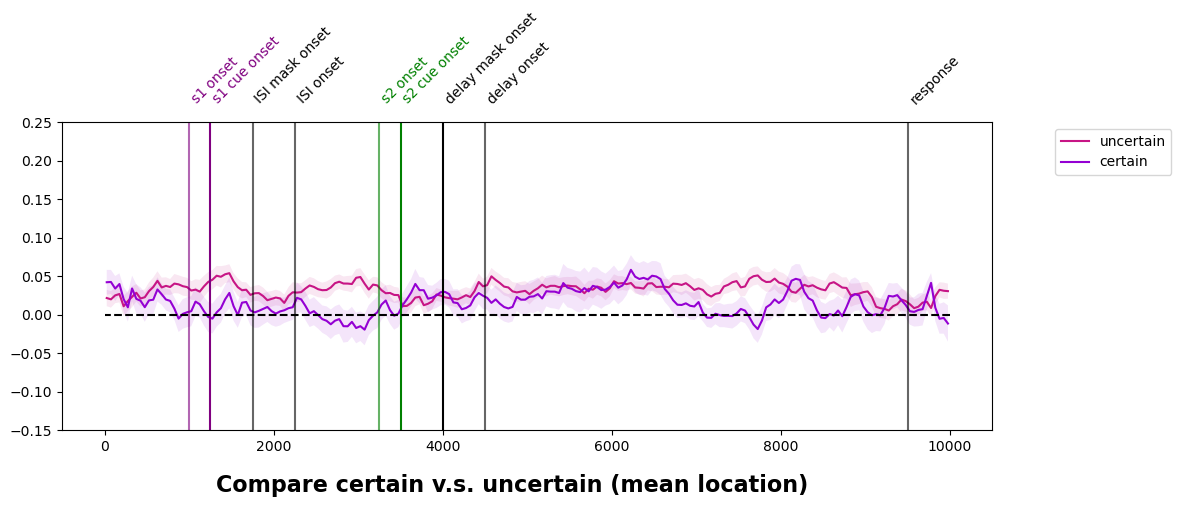

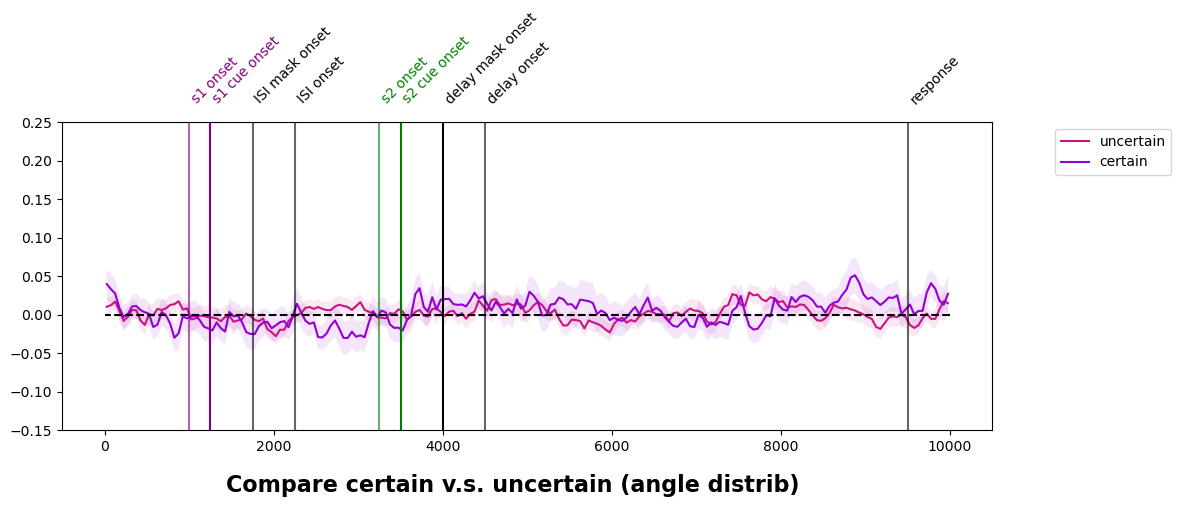

In [32]:
certainty_masks = {
    'uncertain': null_cue_lmb,
    'certain': both_cued_lmb,
}

certainty_colors = {
    'uncertain': 'mediumvioletred',
    'certain': 'darkviolet',
}

for feature_name in ALL_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    to_show_legend = True
    display_lmb_dicts_rsa(
        ax, certainty_masks, ALL_FEATURE_MASKS[feature_name], 'prev_last_response', 
        ALL_FEATURE_MASK_DIST_METHODS[feature_name], colors=certainty_colors, 
        show_legend=to_show_legend)
    plt.suptitle(f'Compare certain v.s. uncertain ({feature_name})', y=0, fontsize=16, fontweight='bold')
    plot_path = os.path.join(PLOTS_FOLDER, f'certainty_last-resp_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

### Split by SD distance

In [33]:
from collections import OrderedDict

def series_angular_diff(x1, x2):
    diffs = np.abs(x1.to_numpy() - x2.to_numpy())
    diffs_2 = 180 - diffs
    actual_diffs = np.min([diffs, diffs_2], axis=0)
    return actual_diffs

sd_masks = {}
sd_val_groups = OrderedDict([
    ('small', (0, 30)),
    ('small-medium', (15, 45)),
    ('medium', (30, 60)),
    ('medium-large', (45, 75)),
    ('large', (60, 90)),
])
for stimid in ['stim_1', 'stim_2']:
    stim_sd_masks = sd_masks.setdefault(stimid, {})
    for sd_name, (low, high) in sd_val_groups.items():
        stim_sd_masks[f'{sd_name}'] = (lambda d, low=low, high=high, stimid=stimid: 
            (
                (series_angular_diff(d[stimid], d['prev_last_response']) >= low) &
                (series_angular_diff(d[stimid], d['prev_last_response']) < high) &
                (d[f'{stimid}_to_report'] | (d['trial_code'] == 1))
            ).to_numpy()
        )

In [34]:
exp_csv = pd.read_csv(os.path.join(DEFAULT_FEATURE_FOLDER, '908', 'behavior.csv'))
print(exp_csv[['stim_1', 'prev_last_response']].head())
exp_mask_lmb = sd_masks['stim_1']['large']
exp_mask = exp_mask_lmb(exp_csv)
print(exp_csv[exp_mask][['stim_1', 'prev_last_response']].head())


       stim_1  prev_last_response
0   53.768502                 NaN
1   95.392638                54.0
2  169.828842               148.0
3   59.178761               163.0
4  114.967475                53.0
       stim_1  prev_last_response
3   59.178761               163.0
8   62.542754               168.0
16  94.165023                22.0
18  69.226384               161.0
19  79.673512                13.0


In [35]:
def plot_stim_sd_rsa(feature_name, target_stim_id, target_stim_name, cmap):
    # set color scale
    condition_shades = [cmap(i) for i in np.linspace(0.3, 0.8, len(sd_val_groups))]
    condition_shades = dict(zip(sd_val_groups.keys(), condition_shades))

    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    to_show_legend = True
    display_lmb_dicts_rsa(
        ax, sd_masks[target_stim_id], 
        ALL_FEATURE_MASKS[feature_name], target_stim_id, 
        ALL_FEATURE_MASK_DIST_METHODS[feature_name], 
        colors=condition_shades, show_legend=to_show_legend)
    to_show_legend = False

    plt.suptitle(f'Compare different sd ({target_stim_name}) ({feature_name})', y=0, fontsize=16, fontweight='bold')
    plot_path = os.path.join(PLOTS_FOLDER, f'sd_stim_{target_stim_name}_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:30,  1.16it/s]


  6%|▌         | 2/36 [00:01<00:29,  1.15it/s]


  8%|▊         | 3/36 [00:02<00:28,  1.14it/s]


 11%|█         | 4/36 [00:03<00:28,  1.14it/s]


 14%|█▍        | 5/36 [00:04<00:27,  1.13it/s]


 17%|█▋        | 6/36 [00:05<00:26,  1.13it/s]


 19%|█▉        | 7/36 [00:06<00:25,  1.12it/s]


 22%|██▏       | 8/36 [00:07<00:24,  1.12it/s]


 25%|██▌       | 9/36 [00:08<00:25,  1.04it/s]


 28%|██▊       | 10/36 [00:09<00:24,  1.07it/s]


 31%|███       | 11/36 [00:09<00:22,  1.09it/s]


 33%|███▎      | 12/36 [00:11<00:23,  1.03it/s]


 36%|███▌      | 13/36 [00:12<00:23,  1.01s/it]


 39%|███▉      | 14/36 [00:13<00:21,  1.02it/s]


 42%|████▏     | 15/36 [00:13<00:19,  1.06it/s]


 44%|████▍     | 16/36 [00:15<00:19,  1.00it/s]


 47%|████▋     | 17/36 [00:16<00:19,  1.03s/it]


 50%|█████     | 18/36 [00:17<00:18,  1.00s/it]


 53%|█████▎    | 19/36 [00:17<00:16,  1.03it/s]


 56%|█████▌    | 20/36 [00:18<00:15,  1.03it/s]


 58%|█████▊    | 21/36 [00:19<00:14,  1.06it/s]


 61%|██████    | 22/36 [00:20<00:13,  1.07it/s]


 64%|██████▍   | 23/36 [00:21<00:11,  1.09it/s]


 67%|██████▋   | 24/36 [00:22<00:11,  1.07it/s]


 69%|██████▉   | 25/36 [00:23<00:10,  1.10it/s]


 72%|███████▏  | 26/36 [00:24<00:09,  1.09it/s]


 75%|███████▌  | 27/36 [00:25<00:08,  1.08it/s]


 78%|███████▊  | 28/36 [00:26<00:07,  1.09it/s]


 81%|████████  | 29/36 [00:27<00:06,  1.07it/s]


 83%|████████▎ | 30/36 [00:28<00:05,  1.07it/s]


 86%|████████▌ | 31/36 [00:29<00:04,  1.07it/s]


 89%|████████▉ | 32/36 [00:30<00:03,  1.07it/s]


 92%|█████████▏| 33/36 [00:30<00:02,  1.07it/s]


 94%|█████████▍| 34/36 [00:31<00:01,  1.07it/s]


 97%|█████████▋| 35/36 [00:33<00:00,  1.01it/s]


100%|██████████| 36/36 [00:34<00:00,  1.03s/it]


100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:32,  1.09it/s]


  6%|▌         | 2/36 [00:01<00:31,  1.08it/s]


  8%|▊         | 3/36 [00:02<00:31,  1.06it/s]


 11%|█         | 4/36 [00:03<00:32,  1.01s/it]


 14%|█▍        | 5/36 [00:04<00:30,  1.02it/s]


 17%|█▋        | 6/36 [00:05<00:28,  1.04it/s]


 19%|█▉        | 7/36 [00:06<00:27,  1.04it/s]


 22%|██▏       | 8/36 [00:07<00:26,  1.04it/s]


 25%|██▌       | 9/36 [00:08<00:27,  1.02s/it]


 28%|██▊       | 10/36 [00:09<00:25,  1.01it/s]


 31%|███       | 11/36 [00:10<00:25,  1.03s/it]


 33%|███▎      | 12/36 [00:11<00:23,  1.01it/s]


 36%|███▌      | 13/36 [00:12<00:23,  1.03s/it]


 39%|███▉      | 14/36 [00:13<00:21,  1.00it/s]


 42%|████▏     | 15/36 [00:14<00:20,  1.03it/s]


 44%|████▍     | 16/36 [00:15<00:19,  1.04it/s]


 47%|████▋     | 17/36 [00:17<00:20,  1.08s/it]


 50%|█████     | 18/36 [00:17<00:18,  1.03s/it]


 53%|█████▎    | 19/36 [00:18<00:17,  1.01s/it]


 56%|█████▌    | 20/36 [00:19<00:16,  1.00s/it]


 58%|█████▊    | 21/36 [00:20<00:14,  1.03it/s]


 61%|██████    | 22/36 [00:21<00:13,  1.04it/s]


 64%|██████▍   | 23/36 [00:22<00:12,  1.05it/s]


 67%|██████▋   | 24/36 [00:23<00:11,  1.06it/s]


 69%|██████▉   | 25/36 [00:24<00:10,  1.10it/s]


 72%|███████▏  | 26/36 [00:25<00:09,  1.02it/s]


 75%|███████▌  | 27/36 [00:26<00:08,  1.03it/s]


 78%|███████▊  | 28/36 [00:27<00:07,  1.06it/s]


 81%|████████  | 29/36 [00:28<00:06,  1.06it/s]


 83%|████████▎ | 30/36 [00:29<00:05,  1.06it/s]


 86%|████████▌ | 31/36 [00:30<00:04,  1.06it/s]


 89%|████████▉ | 32/36 [00:31<00:04,  1.01s/it]


 92%|█████████▏| 33/36 [00:32<00:02,  1.03it/s]


 94%|█████████▍| 34/36 [00:33<00:02,  1.01s/it]


 97%|█████████▋| 35/36 [00:34<00:00,  1.03it/s]


100%|██████████| 36/36 [00:35<00:00,  1.05it/s]


100%|██████████| 36/36 [00:35<00:00,  1.02it/s]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:33,  1.05it/s]


  6%|▌         | 2/36 [00:01<00:31,  1.08it/s]


  8%|▊         | 3/36 [00:02<00:31,  1.06it/s]


 11%|█         | 4/36 [00:03<00:30,  1.06it/s]


 14%|█▍        | 5/36 [00:04<00:29,  1.06it/s]


 17%|█▋        | 6/36 [00:05<00:30,  1.03s/it]


 19%|█▉        | 7/36 [00:07<00:31,  1.07s/it]


 22%|██▏       | 8/36 [00:08<00:30,  1.10s/it]


 25%|██▌       | 9/36 [00:09<00:28,  1.06s/it]


 28%|██▊       | 10/36 [00:10<00:26,  1.03s/it]


 31%|███       | 11/36 [00:11<00:26,  1.05s/it]


 33%|███▎      | 12/36 [00:12<00:25,  1.07s/it]


 36%|███▌      | 13/36 [00:13<00:23,  1.02s/it]


 39%|███▉      | 14/36 [00:14<00:22,  1.01s/it]


 42%|████▏     | 15/36 [00:15<00:20,  1.02it/s]


 44%|████▍     | 16/36 [00:16<00:22,  1.13s/it]


 47%|████▋     | 17/36 [00:17<00:20,  1.08s/it]


 50%|█████     | 18/36 [00:18<00:19,  1.10s/it]


 53%|█████▎    | 19/36 [00:19<00:19,  1.12s/it]


 56%|█████▌    | 20/36 [00:20<00:16,  1.06s/it]


 58%|█████▊    | 21/36 [00:21<00:15,  1.02s/it]


 61%|██████    | 22/36 [00:22<00:14,  1.06s/it]


 64%|██████▍   | 23/36 [00:23<00:13,  1.00s/it]


 67%|██████▋   | 24/36 [00:25<00:13,  1.11s/it]


 69%|██████▉   | 25/36 [00:26<00:11,  1.03s/it]


 72%|███████▏  | 26/36 [00:26<00:10,  1.01s/it]


 75%|███████▌  | 27/36 [00:27<00:08,  1.02it/s]


 78%|███████▊  | 28/36 [00:28<00:07,  1.05it/s]


 81%|████████  | 29/36 [00:29<00:06,  1.05it/s]


 83%|████████▎ | 30/36 [00:30<00:05,  1.07it/s]


 86%|████████▌ | 31/36 [00:31<00:04,  1.06it/s]


 89%|████████▉ | 32/36 [00:32<00:03,  1.06it/s]


 92%|█████████▏| 33/36 [00:33<00:02,  1.06it/s]


 94%|█████████▍| 34/36 [00:34<00:01,  1.06it/s]


 97%|█████████▋| 35/36 [00:35<00:00,  1.07it/s]


100%|██████████| 36/36 [00:36<00:00,  1.07it/s]


100%|██████████| 36/36 [00:36<00:00,  1.01s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:32,  1.06it/s]


  6%|▌         | 2/36 [00:01<00:31,  1.09it/s]


  8%|▊         | 3/36 [00:02<00:30,  1.09it/s]


 11%|█         | 4/36 [00:03<00:28,  1.11it/s]


 14%|█▍        | 5/36 [00:04<00:28,  1.10it/s]


 17%|█▋        | 6/36 [00:05<00:27,  1.09it/s]


 19%|█▉        | 7/36 [00:06<00:26,  1.07it/s]


 22%|██▏       | 8/36 [00:07<00:26,  1.07it/s]


 25%|██▌       | 9/36 [00:08<00:25,  1.07it/s]


 28%|██▊       | 10/36 [00:09<00:23,  1.09it/s]


 31%|███       | 11/36 [00:10<00:24,  1.03it/s]


 33%|███▎      | 12/36 [00:11<00:22,  1.05it/s]


 36%|███▌      | 13/36 [00:12<00:21,  1.07it/s]


 39%|███▉      | 14/36 [00:13<00:20,  1.08it/s]


 42%|████▏     | 15/36 [00:14<00:20,  1.02it/s]


 44%|████▍     | 16/36 [00:15<00:19,  1.03it/s]


 47%|████▋     | 17/36 [00:16<00:18,  1.04it/s]


 50%|█████     | 18/36 [00:16<00:17,  1.04it/s]


 53%|█████▎    | 19/36 [00:17<00:16,  1.04it/s]


 56%|█████▌    | 20/36 [00:18<00:15,  1.06it/s]


 58%|█████▊    | 21/36 [00:19<00:14,  1.06it/s]


 61%|██████    | 22/36 [00:20<00:13,  1.06it/s]


 64%|██████▍   | 23/36 [00:21<00:11,  1.08it/s]


 67%|██████▋   | 24/36 [00:22<00:10,  1.10it/s]


 69%|██████▉   | 25/36 [00:23<00:09,  1.12it/s]


 72%|███████▏  | 26/36 [00:24<00:10,  1.09s/it]


 75%|███████▌  | 27/36 [00:25<00:09,  1.05s/it]


 78%|███████▊  | 28/36 [00:26<00:08,  1.06s/it]


 81%|████████  | 29/36 [00:27<00:07,  1.02s/it]


 83%|████████▎ | 30/36 [00:28<00:06,  1.05s/it]


 86%|████████▌ | 31/36 [00:29<00:05,  1.02s/it]


 89%|████████▉ | 32/36 [00:31<00:04,  1.05s/it]


 92%|█████████▏| 33/36 [00:31<00:03,  1.02s/it]


 94%|█████████▍| 34/36 [00:33<00:02,  1.12s/it]


 97%|█████████▋| 35/36 [00:34<00:01,  1.13s/it]


100%|██████████| 36/36 [00:35<00:00,  1.12s/it]


100%|██████████| 36/36 [00:35<00:00,  1.01it/s]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:40,  1.16s/it]


  6%|▌         | 2/36 [00:02<00:34,  1.01s/it]


  8%|▊         | 3/36 [00:03<00:32,  1.02it/s]


 11%|█         | 4/36 [00:04<00:36,  1.13s/it]


 14%|█▍        | 5/36 [00:05<00:37,  1.21s/it]


 17%|█▋        | 6/36 [00:06<00:35,  1.19s/it]


 19%|█▉        | 7/36 [00:07<00:32,  1.11s/it]


 22%|██▏       | 8/36 [00:08<00:31,  1.12s/it]


 25%|██▌       | 9/36 [00:09<00:28,  1.05s/it]


 28%|██▊       | 10/36 [00:11<00:30,  1.15s/it]


 31%|███       | 11/36 [00:12<00:28,  1.16s/it]


 33%|███▎      | 12/36 [00:13<00:27,  1.16s/it]


 36%|███▌      | 13/36 [00:14<00:25,  1.10s/it]


 39%|███▉      | 14/36 [00:15<00:23,  1.07s/it]


 42%|████▏     | 15/36 [00:16<00:21,  1.02s/it]


 44%|████▍     | 16/36 [00:17<00:19,  1.01it/s]


 47%|████▋     | 17/36 [00:18<00:18,  1.02it/s]


 50%|█████     | 18/36 [00:19<00:17,  1.02it/s]


 53%|█████▎    | 19/36 [00:20<00:16,  1.03it/s]


 56%|█████▌    | 20/36 [00:21<00:17,  1.09s/it]


 58%|█████▊    | 21/36 [00:23<00:17,  1.19s/it]


 61%|██████    | 22/36 [00:23<00:15,  1.11s/it]


 64%|██████▍   | 23/36 [00:24<00:13,  1.05s/it]


 67%|██████▋   | 24/36 [00:25<00:12,  1.07s/it]


 69%|██████▉   | 25/36 [00:26<00:11,  1.01s/it]


 72%|███████▏  | 26/36 [00:27<00:09,  1.00it/s]


 75%|███████▌  | 27/36 [00:28<00:08,  1.01it/s]


 78%|███████▊  | 28/36 [00:29<00:08,  1.01s/it]


 81%|████████  | 29/36 [00:30<00:06,  1.01it/s]


 83%|████████▎ | 30/36 [00:31<00:05,  1.03it/s]


 86%|████████▌ | 31/36 [00:32<00:05,  1.02s/it]


 89%|████████▉ | 32/36 [00:33<00:04,  1.04s/it]


 92%|█████████▏| 33/36 [00:34<00:02,  1.00it/s]


 94%|█████████▍| 34/36 [00:35<00:01,  1.02it/s]


 97%|█████████▋| 35/36 [00:36<00:01,  1.02s/it]


100%|██████████| 36/36 [00:37<00:00,  1.01it/s]


100%|██████████| 36/36 [00:37<00:00,  1.05s/it]

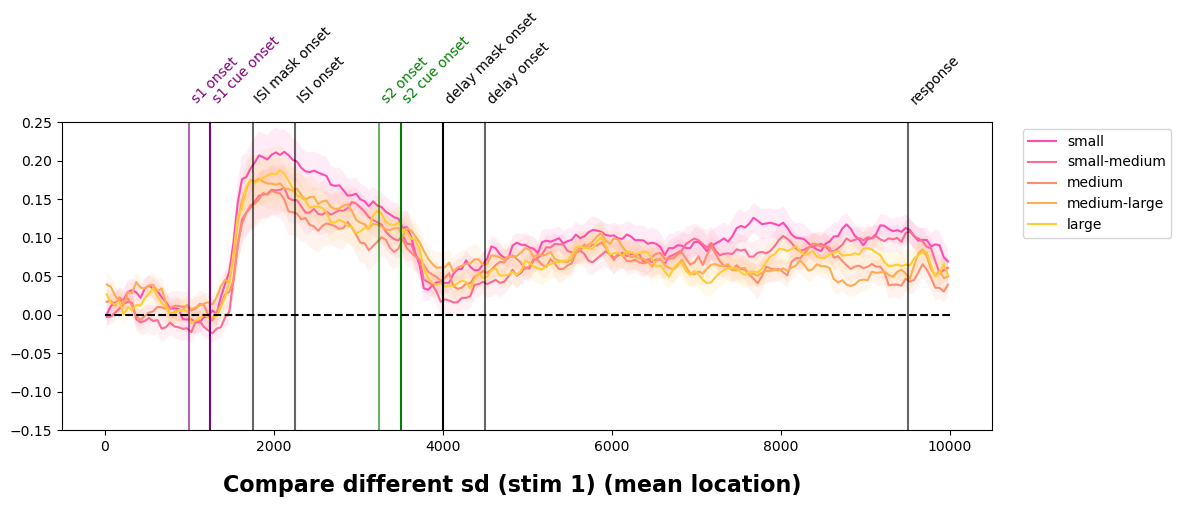

In [36]:
cmap = plt.get_cmap("spring")
plot_stim_sd_rsa('mean location', 'stim_1', 'stim 1', cmap)


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:35,  1.01s/it]


  6%|▌         | 2/36 [00:01<00:33,  1.02it/s]


  8%|▊         | 3/36 [00:03<00:35,  1.07s/it]


 11%|█         | 4/36 [00:04<00:32,  1.01s/it]


 14%|█▍        | 5/36 [00:04<00:30,  1.02it/s]


 17%|█▋        | 6/36 [00:06<00:31,  1.04s/it]


 19%|█▉        | 7/36 [00:07<00:31,  1.07s/it]


 22%|██▏       | 8/36 [00:08<00:30,  1.09s/it]


 25%|██▌       | 9/36 [00:09<00:29,  1.09s/it]


 28%|██▊       | 10/36 [00:10<00:30,  1.18s/it]


 31%|███       | 11/36 [00:11<00:27,  1.10s/it]


 33%|███▎      | 12/36 [00:12<00:25,  1.06s/it]


 36%|███▌      | 13/36 [00:14<00:26,  1.15s/it]


 39%|███▉      | 14/36 [00:15<00:23,  1.09s/it]


 42%|████▏     | 15/36 [00:15<00:21,  1.03s/it]


 44%|████▍     | 16/36 [00:16<00:19,  1.00it/s]


 47%|████▋     | 17/36 [00:17<00:18,  1.03it/s]


 50%|█████     | 18/36 [00:18<00:17,  1.04it/s]


 53%|█████▎    | 19/36 [00:19<00:16,  1.05it/s]


 56%|█████▌    | 20/36 [00:20<00:15,  1.06it/s]


 58%|█████▊    | 21/36 [00:21<00:14,  1.07it/s]


 61%|██████    | 22/36 [00:22<00:12,  1.08it/s]


 64%|██████▍   | 23/36 [00:23<00:11,  1.09it/s]


 67%|██████▋   | 24/36 [00:24<00:11,  1.09it/s]


 69%|██████▉   | 25/36 [00:25<00:09,  1.10it/s]


 72%|███████▏  | 26/36 [00:26<00:09,  1.08it/s]


 75%|███████▌  | 27/36 [00:27<00:08,  1.07it/s]


 78%|███████▊  | 28/36 [00:27<00:07,  1.09it/s]


 81%|████████  | 29/36 [00:28<00:06,  1.08it/s]


 83%|████████▎ | 30/36 [00:29<00:05,  1.09it/s]


 86%|████████▌ | 31/36 [00:30<00:04,  1.09it/s]


 89%|████████▉ | 32/36 [00:31<00:03,  1.08it/s]


 92%|█████████▏| 33/36 [00:32<00:02,  1.01it/s]


 94%|█████████▍| 34/36 [00:33<00:02,  1.02s/it]


 97%|█████████▋| 35/36 [00:34<00:00,  1.00it/s]


100%|██████████| 36/36 [00:36<00:00,  1.10s/it]


100%|██████████| 36/36 [00:36<00:00,  1.00s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:33,  1.05it/s]


  6%|▌         | 2/36 [00:02<00:36,  1.06s/it]


  8%|▊         | 3/36 [00:03<00:33,  1.02s/it]


 11%|█         | 4/36 [00:03<00:31,  1.03it/s]


 14%|█▍        | 5/36 [00:04<00:29,  1.04it/s]


 17%|█▋        | 6/36 [00:05<00:28,  1.05it/s]


 19%|█▉        | 7/36 [00:06<00:27,  1.05it/s]


 22%|██▏       | 8/36 [00:07<00:26,  1.05it/s]


 25%|██▌       | 9/36 [00:08<00:25,  1.06it/s]


 28%|██▊       | 10/36 [00:09<00:24,  1.06it/s]


 31%|███       | 11/36 [00:10<00:23,  1.07it/s]


 33%|███▎      | 12/36 [00:11<00:22,  1.07it/s]


 36%|███▌      | 13/36 [00:12<00:21,  1.07it/s]


 39%|███▉      | 14/36 [00:13<00:20,  1.06it/s]


 42%|████▏     | 15/36 [00:14<00:19,  1.06it/s]


 44%|████▍     | 16/36 [00:15<00:20,  1.01s/it]


 47%|████▋     | 17/36 [00:16<00:20,  1.05s/it]


 50%|█████     | 18/36 [00:17<00:18,  1.03s/it]


 53%|█████▎    | 19/36 [00:18<00:17,  1.01s/it]


 56%|█████▌    | 20/36 [00:19<00:15,  1.02it/s]


 58%|█████▊    | 21/36 [00:20<00:14,  1.04it/s]


 61%|██████    | 22/36 [00:21<00:13,  1.05it/s]


 64%|██████▍   | 23/36 [00:22<00:12,  1.08it/s]


 67%|██████▋   | 24/36 [00:23<00:11,  1.09it/s]


 69%|██████▉   | 25/36 [00:23<00:09,  1.10it/s]


 72%|███████▏  | 26/36 [00:24<00:09,  1.10it/s]


 75%|███████▌  | 27/36 [00:25<00:08,  1.10it/s]


 78%|███████▊  | 28/36 [00:26<00:07,  1.10it/s]


 81%|████████  | 29/36 [00:27<00:06,  1.08it/s]


 83%|████████▎ | 30/36 [00:28<00:05,  1.09it/s]


 86%|████████▌ | 31/36 [00:29<00:04,  1.08it/s]


 89%|████████▉ | 32/36 [00:30<00:03,  1.08it/s]


 92%|█████████▏| 33/36 [00:31<00:02,  1.06it/s]


 94%|█████████▍| 34/36 [00:32<00:01,  1.06it/s]


 97%|█████████▋| 35/36 [00:33<00:00,  1.01it/s]


100%|██████████| 36/36 [00:34<00:00,  1.03s/it]


100%|██████████| 36/36 [00:34<00:00,  1.04it/s]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:33,  1.04it/s]


  6%|▌         | 2/36 [00:01<00:32,  1.04it/s]


  8%|▊         | 3/36 [00:02<00:32,  1.03it/s]


 11%|█         | 4/36 [00:03<00:30,  1.05it/s]


 14%|█▍        | 5/36 [00:04<00:29,  1.05it/s]


 17%|█▋        | 6/36 [00:05<00:30,  1.02s/it]


 19%|█▉        | 7/36 [00:06<00:29,  1.00s/it]


 22%|██▏       | 8/36 [00:08<00:29,  1.06s/it]


 25%|██▌       | 9/36 [00:09<00:27,  1.02s/it]


 28%|██▊       | 10/36 [00:09<00:25,  1.01it/s]


 31%|███       | 11/36 [00:10<00:24,  1.02it/s]


 33%|███▎      | 12/36 [00:12<00:24,  1.03s/it]


 36%|███▌      | 13/36 [00:12<00:22,  1.00it/s]


 39%|███▉      | 14/36 [00:13<00:21,  1.01it/s]


 42%|████▏     | 15/36 [00:14<00:20,  1.02it/s]


 44%|████▍     | 16/36 [00:15<00:19,  1.03it/s]


 47%|████▋     | 17/36 [00:16<00:18,  1.04it/s]


 50%|█████     | 18/36 [00:17<00:18,  1.02s/it]


 53%|█████▎    | 19/36 [00:19<00:19,  1.13s/it]


 56%|█████▌    | 20/36 [00:20<00:19,  1.20s/it]


 58%|█████▊    | 21/36 [00:21<00:16,  1.12s/it]


 61%|██████    | 22/36 [00:22<00:15,  1.07s/it]


 64%|██████▍   | 23/36 [00:23<00:13,  1.03s/it]


 67%|██████▋   | 24/36 [00:24<00:12,  1.01s/it]


 69%|██████▉   | 25/36 [00:25<00:11,  1.03s/it]


 72%|███████▏  | 26/36 [00:26<00:09,  1.01it/s]


 75%|███████▌  | 27/36 [00:27<00:08,  1.02it/s]


 78%|███████▊  | 28/36 [00:28<00:07,  1.05it/s]


 81%|████████  | 29/36 [00:29<00:06,  1.05it/s]


 83%|████████▎ | 30/36 [00:30<00:05,  1.05it/s]


 86%|████████▌ | 31/36 [00:31<00:05,  1.01s/it]


 89%|████████▉ | 32/36 [00:32<00:03,  1.01it/s]


 92%|█████████▏| 33/36 [00:33<00:02,  1.01it/s]


 94%|█████████▍| 34/36 [00:34<00:01,  1.02it/s]


 97%|█████████▋| 35/36 [00:35<00:00,  1.03it/s]


100%|██████████| 36/36 [00:36<00:00,  1.01s/it]


100%|██████████| 36/36 [00:36<00:00,  1.01s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:33,  1.04it/s]


  6%|▌         | 2/36 [00:01<00:32,  1.05it/s]


  8%|▊         | 3/36 [00:03<00:34,  1.05s/it]


 11%|█         | 4/36 [00:03<00:31,  1.02it/s]


 14%|█▍        | 5/36 [00:04<00:29,  1.04it/s]


 17%|█▋        | 6/36 [00:05<00:28,  1.06it/s]


 19%|█▉        | 7/36 [00:06<00:27,  1.06it/s]


 22%|██▏       | 8/36 [00:07<00:26,  1.07it/s]


 25%|██▌       | 9/36 [00:08<00:27,  1.00s/it]


 28%|██▊       | 10/36 [00:09<00:25,  1.01it/s]


 31%|███       | 11/36 [00:10<00:25,  1.04s/it]


 33%|███▎      | 12/36 [00:11<00:25,  1.06s/it]


 36%|███▌      | 13/36 [00:12<00:23,  1.02s/it]


 39%|███▉      | 14/36 [00:14<00:23,  1.06s/it]


 42%|████▏     | 15/36 [00:14<00:21,  1.02s/it]


 44%|████▍     | 16/36 [00:15<00:19,  1.01it/s]


 47%|████▋     | 17/36 [00:17<00:19,  1.04s/it]


 50%|█████     | 18/36 [00:18<00:18,  1.02s/it]


 53%|█████▎    | 19/36 [00:19<00:17,  1.05s/it]


 56%|█████▌    | 20/36 [00:20<00:16,  1.01s/it]


 58%|█████▊    | 21/36 [00:21<00:14,  1.02it/s]


 61%|██████    | 22/36 [00:21<00:13,  1.04it/s]


 64%|██████▍   | 23/36 [00:23<00:13,  1.01s/it]


 67%|██████▋   | 24/36 [00:23<00:11,  1.01it/s]


 69%|██████▉   | 25/36 [00:24<00:10,  1.05it/s]


 72%|███████▏  | 26/36 [00:26<00:10,  1.01s/it]


 75%|███████▌  | 27/36 [00:27<00:09,  1.07s/it]


 78%|███████▊  | 28/36 [00:28<00:09,  1.14s/it]


 81%|████████  | 29/36 [00:29<00:07,  1.08s/it]


 83%|████████▎ | 30/36 [00:30<00:06,  1.03s/it]


 86%|████████▌ | 31/36 [00:31<00:04,  1.00it/s]


 89%|████████▉ | 32/36 [00:32<00:04,  1.05s/it]


 92%|█████████▏| 33/36 [00:33<00:03,  1.07s/it]


 94%|█████████▍| 34/36 [00:34<00:02,  1.14s/it]


 97%|█████████▋| 35/36 [00:35<00:01,  1.07s/it]


100%|██████████| 36/36 [00:36<00:00,  1.10s/it]


100%|██████████| 36/36 [00:36<00:00,  1.03s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:33,  1.05it/s]


  6%|▌         | 2/36 [00:01<00:32,  1.05it/s]


  8%|▊         | 3/36 [00:03<00:34,  1.04s/it]


 11%|█         | 4/36 [00:03<00:31,  1.01it/s]


 14%|█▍        | 5/36 [00:05<00:32,  1.05s/it]


 17%|█▋        | 6/36 [00:06<00:30,  1.02s/it]


 19%|█▉        | 7/36 [00:07<00:28,  1.01it/s]


 22%|██▏       | 8/36 [00:07<00:27,  1.02it/s]


 25%|██▌       | 9/36 [00:08<00:26,  1.03it/s]


 28%|██▊       | 10/36 [00:09<00:24,  1.04it/s]


 31%|███       | 11/36 [00:10<00:23,  1.05it/s]


 33%|███▎      | 12/36 [00:11<00:22,  1.08it/s]


 36%|███▌      | 13/36 [00:12<00:21,  1.08it/s]


 39%|███▉      | 14/36 [00:13<00:20,  1.08it/s]


 42%|████▏     | 15/36 [00:14<00:19,  1.08it/s]


 44%|████▍     | 16/36 [00:15<00:18,  1.06it/s]


 47%|████▋     | 17/36 [00:16<00:18,  1.05it/s]


 50%|█████     | 18/36 [00:17<00:17,  1.03it/s]


 53%|█████▎    | 19/36 [00:18<00:16,  1.03it/s]


 56%|█████▌    | 20/36 [00:19<00:16,  1.02s/it]


 58%|█████▊    | 21/36 [00:20<00:15,  1.00s/it]


 61%|██████    | 22/36 [00:21<00:13,  1.02it/s]


 64%|██████▍   | 23/36 [00:22<00:12,  1.05it/s]


 67%|██████▋   | 24/36 [00:23<00:11,  1.06it/s]


 69%|██████▉   | 25/36 [00:24<00:10,  1.02it/s]


 72%|███████▏  | 26/36 [00:25<00:10,  1.04s/it]


 75%|███████▌  | 27/36 [00:26<00:09,  1.08s/it]


 78%|███████▊  | 28/36 [00:27<00:08,  1.03s/it]


 81%|████████  | 29/36 [00:28<00:07,  1.01s/it]


 83%|████████▎ | 30/36 [00:29<00:05,  1.01it/s]


 86%|████████▌ | 31/36 [00:30<00:04,  1.01it/s]


 89%|████████▉ | 32/36 [00:31<00:03,  1.02it/s]


 92%|█████████▏| 33/36 [00:32<00:03,  1.02s/it]


 94%|█████████▍| 34/36 [00:33<00:01,  1.00it/s]


 97%|█████████▋| 35/36 [00:34<00:00,  1.03it/s]


100%|██████████| 36/36 [00:35<00:00,  1.05it/s]


100%|██████████| 36/36 [00:35<00:00,  1.02it/s]

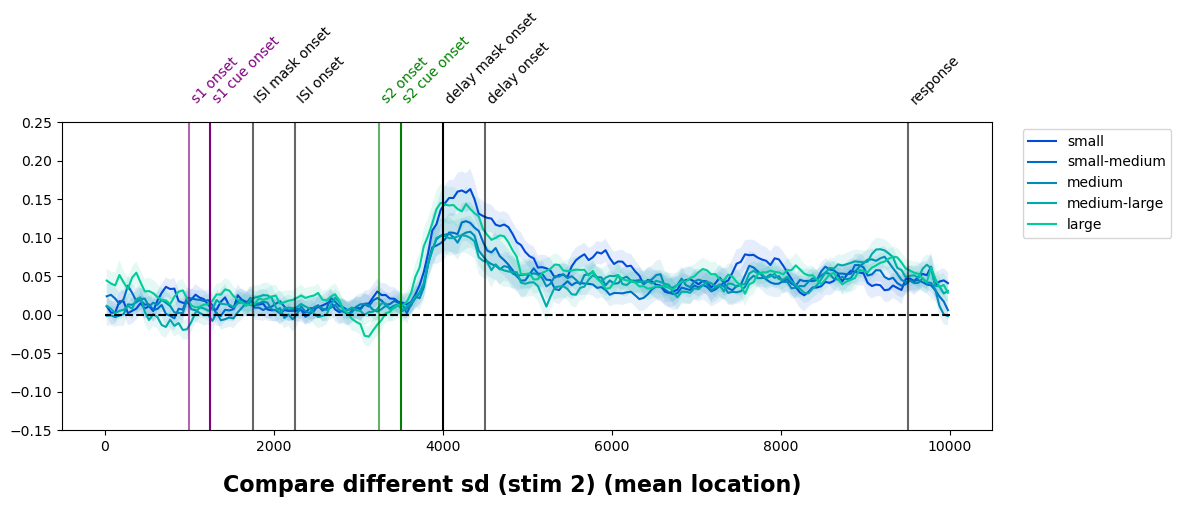

In [37]:
cmap = plt.get_cmap("winter")
plot_stim_sd_rsa('mean location', 'stim_2', 'stim 2', cmap)


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:00<00:33,  1.05it/s]


  6%|▌         | 2/36 [00:02<00:44,  1.31s/it]


  8%|▊         | 3/36 [00:03<00:39,  1.20s/it]


 11%|█         | 4/36 [00:04<00:36,  1.13s/it]


 14%|█▍        | 5/36 [00:05<00:33,  1.08s/it]


 17%|█▋        | 6/36 [00:07<00:35,  1.19s/it]


 19%|█▉        | 7/36 [00:08<00:33,  1.14s/it]


 22%|██▏       | 8/36 [00:09<00:30,  1.11s/it]


 25%|██▌       | 9/36 [00:10<00:29,  1.08s/it]


 28%|██▊       | 10/36 [00:11<00:27,  1.06s/it]


 31%|███       | 11/36 [00:12<00:26,  1.05s/it]


 33%|███▎      | 12/36 [00:13<00:25,  1.04s/it]


 36%|███▌      | 13/36 [00:14<00:23,  1.04s/it]


 39%|███▉      | 14/36 [00:15<00:24,  1.10s/it]


 42%|████▏     | 15/36 [00:16<00:22,  1.08s/it]


 44%|████▍     | 16/36 [00:17<00:21,  1.07s/it]


 47%|████▋     | 17/36 [00:18<00:20,  1.06s/it]


 50%|█████     | 18/36 [00:19<00:19,  1.06s/it]


 53%|█████▎    | 19/36 [00:20<00:19,  1.15s/it]


 56%|█████▌    | 20/36 [00:22<00:19,  1.19s/it]


 58%|█████▊    | 21/36 [00:23<00:17,  1.20s/it]


 61%|██████    | 22/36 [00:24<00:17,  1.23s/it]


 64%|██████▍   | 23/36 [00:25<00:15,  1.15s/it]


 67%|██████▋   | 24/36 [00:26<00:13,  1.13s/it]


 69%|██████▉   | 25/36 [00:27<00:11,  1.06s/it]


 72%|███████▏  | 26/36 [00:29<00:13,  1.32s/it]


 75%|███████▌  | 27/36 [00:30<00:11,  1.31s/it]


 78%|███████▊  | 28/36 [00:32<00:11,  1.47s/it]


 81%|████████  | 29/36 [00:34<00:09,  1.40s/it]


 83%|████████▎ | 30/36 [00:35<00:08,  1.42s/it]


 86%|████████▌ | 31/36 [00:37<00:07,  1.48s/it]


 89%|████████▉ | 32/36 [00:38<00:05,  1.48s/it]


 92%|█████████▏| 33/36 [00:39<00:04,  1.42s/it]


 94%|█████████▍| 34/36 [00:40<00:02,  1.29s/it]


 97%|█████████▋| 35/36 [00:42<00:01,  1.26s/it]


100%|██████████| 36/36 [00:43<00:00,  1.30s/it]


100%|██████████| 36/36 [00:43<00:00,  1.21s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:50,  1.43s/it]


  6%|▌         | 2/36 [00:02<00:40,  1.20s/it]


  8%|▊         | 3/36 [00:04<00:44,  1.35s/it]


 11%|█         | 4/36 [00:05<00:45,  1.41s/it]


 14%|█▍        | 5/36 [00:06<00:41,  1.34s/it]


 17%|█▋        | 6/36 [00:07<00:36,  1.23s/it]


 19%|█▉        | 7/36 [00:09<00:39,  1.37s/it]


 22%|██▏       | 8/36 [00:10<00:35,  1.28s/it]


 25%|██▌       | 9/36 [00:11<00:32,  1.19s/it]


 28%|██▊       | 10/36 [00:12<00:30,  1.19s/it]


 31%|███       | 11/36 [00:13<00:30,  1.21s/it]


 33%|███▎      | 12/36 [00:14<00:27,  1.14s/it]


 36%|███▌      | 13/36 [00:15<00:25,  1.09s/it]


 39%|███▉      | 14/36 [00:16<00:23,  1.07s/it]


 42%|████▏     | 15/36 [00:18<00:23,  1.12s/it]


 44%|████▍     | 16/36 [00:19<00:22,  1.15s/it]


 47%|████▋     | 17/36 [00:20<00:23,  1.24s/it]


 50%|█████     | 18/36 [00:22<00:24,  1.33s/it]


 53%|█████▎    | 19/36 [00:23<00:22,  1.31s/it]


 56%|█████▌    | 20/36 [00:25<00:22,  1.42s/it]


 58%|█████▊    | 21/36 [00:26<00:21,  1.41s/it]


 61%|██████    | 22/36 [00:27<00:19,  1.36s/it]


 64%|██████▍   | 23/36 [00:29<00:18,  1.46s/it]


 67%|██████▋   | 24/36 [00:30<00:16,  1.34s/it]


 69%|██████▉   | 25/36 [00:31<00:14,  1.29s/it]


 72%|███████▏  | 26/36 [00:33<00:12,  1.27s/it]


 75%|███████▌  | 27/36 [00:34<00:10,  1.20s/it]


 78%|███████▊  | 28/36 [00:35<00:08,  1.12s/it]


 81%|████████  | 29/36 [00:36<00:08,  1.14s/it]


 83%|████████▎ | 30/36 [00:37<00:06,  1.08s/it]


 86%|████████▌ | 31/36 [00:38<00:05,  1.18s/it]


 89%|████████▉ | 32/36 [00:40<00:05,  1.28s/it]


 92%|█████████▏| 33/36 [00:41<00:03,  1.20s/it]


 94%|█████████▍| 34/36 [00:42<00:02,  1.21s/it]


 97%|█████████▋| 35/36 [00:43<00:01,  1.15s/it]


100%|██████████| 36/36 [00:44<00:00,  1.17s/it]


100%|██████████| 36/36 [00:44<00:00,  1.24s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:52,  1.49s/it]


  6%|▌         | 2/36 [00:02<00:41,  1.23s/it]


  8%|▊         | 3/36 [00:03<00:43,  1.33s/it]


 11%|█         | 4/36 [00:06<00:56,  1.75s/it]


 14%|█▍        | 5/36 [00:07<00:47,  1.55s/it]


 17%|█▋        | 6/36 [00:08<00:43,  1.45s/it]


 19%|█▉        | 7/36 [00:09<00:38,  1.33s/it]


 22%|██▏       | 8/36 [00:10<00:34,  1.25s/it]


 25%|██▌       | 9/36 [00:12<00:34,  1.26s/it]


 28%|██▊       | 10/36 [00:13<00:36,  1.39s/it]


 31%|███       | 11/36 [00:15<00:39,  1.57s/it]


 33%|███▎      | 12/36 [00:17<00:36,  1.53s/it]


 36%|███▌      | 13/36 [00:18<00:34,  1.48s/it]


 39%|███▉      | 14/36 [00:20<00:32,  1.48s/it]


 42%|████▏     | 15/36 [00:21<00:27,  1.32s/it]


 44%|████▍     | 16/36 [00:22<00:27,  1.37s/it]


 47%|████▋     | 17/36 [00:23<00:24,  1.29s/it]


 50%|█████     | 18/36 [00:25<00:25,  1.39s/it]


 53%|█████▎    | 19/36 [00:27<00:24,  1.46s/it]


 56%|█████▌    | 20/36 [00:28<00:25,  1.56s/it]


 58%|█████▊    | 21/36 [00:30<00:22,  1.52s/it]


 61%|██████    | 22/36 [00:31<00:19,  1.37s/it]


 64%|██████▍   | 23/36 [00:32<00:16,  1.25s/it]


 67%|██████▋   | 24/36 [00:33<00:16,  1.40s/it]


 69%|██████▉   | 25/36 [00:35<00:14,  1.31s/it]


 72%|███████▏  | 26/36 [00:36<00:13,  1.36s/it]


 75%|███████▌  | 27/36 [00:38<00:13,  1.45s/it]


 78%|███████▊  | 28/36 [00:39<00:10,  1.35s/it]


 81%|████████  | 29/36 [00:40<00:08,  1.25s/it]


 83%|████████▎ | 30/36 [00:41<00:07,  1.32s/it]


 86%|████████▌ | 31/36 [00:43<00:07,  1.42s/it]


 89%|████████▉ | 32/36 [00:44<00:05,  1.45s/it]


 92%|█████████▏| 33/36 [00:46<00:04,  1.52s/it]


 94%|█████████▍| 34/36 [00:48<00:03,  1.51s/it]


 97%|█████████▋| 35/36 [00:49<00:01,  1.57s/it]


100%|██████████| 36/36 [00:51<00:00,  1.47s/it]


100%|██████████| 36/36 [00:51<00:00,  1.42s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:43,  1.25s/it]


  6%|▌         | 2/36 [00:02<00:41,  1.21s/it]


  8%|▊         | 3/36 [00:03<00:43,  1.33s/it]


 11%|█         | 4/36 [00:05<00:47,  1.48s/it]


 14%|█▍        | 5/36 [00:07<00:48,  1.57s/it]


 17%|█▋        | 6/36 [00:08<00:43,  1.46s/it]


 19%|█▉        | 7/36 [00:09<00:41,  1.42s/it]


 22%|██▏       | 8/36 [00:11<00:39,  1.42s/it]


 25%|██▌       | 9/36 [00:12<00:38,  1.42s/it]


 28%|██▊       | 10/36 [00:13<00:33,  1.29s/it]


 31%|███       | 11/36 [00:15<00:33,  1.35s/it]


 33%|███▎      | 12/36 [00:16<00:31,  1.30s/it]


 36%|███▌      | 13/36 [00:17<00:29,  1.28s/it]


 39%|███▉      | 14/36 [00:20<00:37,  1.70s/it]


 42%|████▏     | 15/36 [00:21<00:31,  1.49s/it]


 44%|████▍     | 16/36 [00:23<00:32,  1.64s/it]


 47%|████▋     | 17/36 [00:25<00:33,  1.78s/it]


 50%|█████     | 18/36 [00:27<00:32,  1.83s/it]


 53%|█████▎    | 19/36 [00:30<00:35,  2.07s/it]


 56%|█████▌    | 20/36 [00:32<00:36,  2.25s/it]


 58%|█████▊    | 21/36 [00:33<00:29,  1.96s/it]


 61%|██████    | 22/36 [00:35<00:27,  1.96s/it]


 64%|██████▍   | 23/36 [00:37<00:22,  1.72s/it]


 67%|██████▋   | 24/36 [00:39<00:21,  1.77s/it]


 69%|██████▉   | 25/36 [00:40<00:17,  1.63s/it]


 72%|███████▏  | 26/36 [00:41<00:14,  1.45s/it]


 75%|███████▌  | 27/36 [00:43<00:13,  1.52s/it]


 78%|███████▊  | 28/36 [00:44<00:11,  1.41s/it]


 81%|████████  | 29/36 [00:45<00:10,  1.44s/it]


 83%|████████▎ | 30/36 [00:47<00:08,  1.49s/it]


 86%|████████▌ | 31/36 [00:48<00:07,  1.51s/it]


 89%|████████▉ | 32/36 [00:49<00:05,  1.36s/it]


 92%|█████████▏| 33/36 [00:51<00:04,  1.53s/it]


 94%|█████████▍| 34/36 [00:53<00:03,  1.58s/it]


 97%|█████████▋| 35/36 [00:55<00:01,  1.60s/it]


100%|██████████| 36/36 [00:56<00:00,  1.48s/it]


100%|██████████| 36/36 [00:56<00:00,  1.56s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:42,  1.22s/it]


  6%|▌         | 2/36 [00:02<00:41,  1.23s/it]


  8%|▊         | 3/36 [00:03<00:43,  1.32s/it]


 11%|█         | 4/36 [00:05<00:43,  1.35s/it]


 14%|█▍        | 5/36 [00:07<00:46,  1.50s/it]


 17%|█▋        | 6/36 [00:09<00:52,  1.74s/it]


 19%|█▉        | 7/36 [00:10<00:45,  1.58s/it]


 22%|██▏       | 8/36 [00:12<00:44,  1.59s/it]


 25%|██▌       | 9/36 [00:13<00:39,  1.47s/it]


 28%|██▊       | 10/36 [00:14<00:38,  1.48s/it]


 31%|███       | 11/36 [00:16<00:36,  1.47s/it]


 33%|███▎      | 12/36 [00:17<00:31,  1.33s/it]


 36%|███▌      | 13/36 [00:19<00:36,  1.59s/it]


 39%|███▉      | 14/36 [00:21<00:35,  1.62s/it]


 42%|████▏     | 15/36 [00:22<00:34,  1.66s/it]


 44%|████▍     | 16/36 [00:24<00:32,  1.62s/it]


 47%|████▋     | 17/36 [00:25<00:28,  1.50s/it]


 50%|█████     | 18/36 [00:27<00:29,  1.62s/it]


 53%|█████▎    | 19/36 [00:29<00:29,  1.73s/it]


 56%|█████▌    | 20/36 [00:31<00:27,  1.70s/it]


 58%|█████▊    | 21/36 [00:32<00:25,  1.70s/it]


 61%|██████    | 22/36 [00:34<00:21,  1.55s/it]


 64%|██████▍   | 23/36 [00:35<00:19,  1.51s/it]


 67%|██████▋   | 24/36 [00:36<00:17,  1.49s/it]


 69%|██████▉   | 25/36 [00:37<00:14,  1.32s/it]


 72%|███████▏  | 26/36 [00:38<00:12,  1.23s/it]


 75%|███████▌  | 27/36 [00:39<00:10,  1.16s/it]


 78%|███████▊  | 28/36 [00:41<00:10,  1.25s/it]


 81%|████████  | 29/36 [00:42<00:09,  1.29s/it]


 83%|████████▎ | 30/36 [00:44<00:09,  1.51s/it]


 86%|████████▌ | 31/36 [00:46<00:07,  1.49s/it]


 89%|████████▉ | 32/36 [00:48<00:06,  1.67s/it]


 92%|█████████▏| 33/36 [00:49<00:04,  1.54s/it]


 94%|█████████▍| 34/36 [00:50<00:02,  1.39s/it]


 97%|█████████▋| 35/36 [00:51<00:01,  1.39s/it]


100%|██████████| 36/36 [00:53<00:00,  1.40s/it]


100%|██████████| 36/36 [00:53<00:00,  1.48s/it]

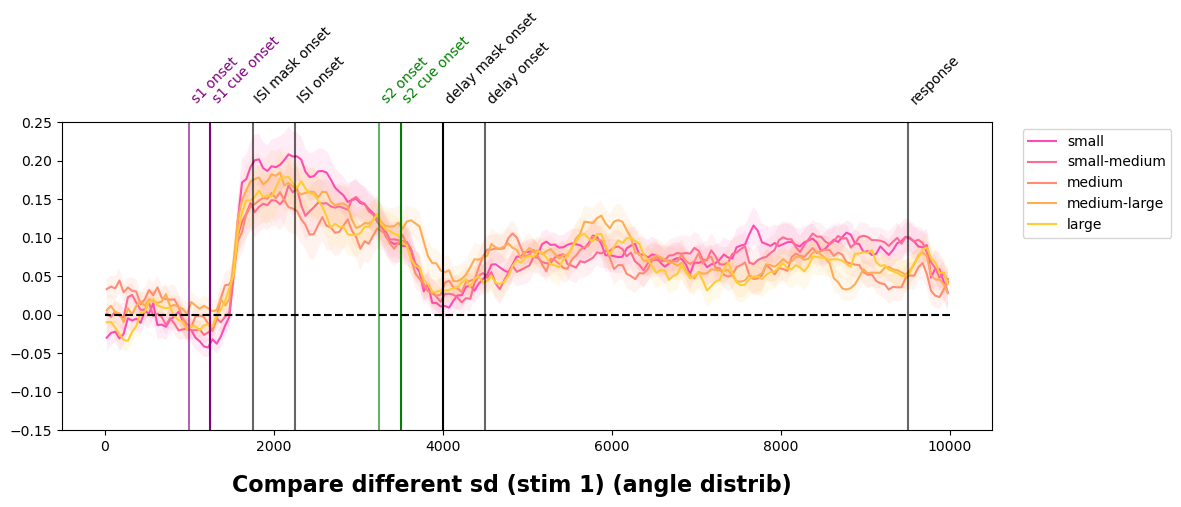

In [38]:
cmap = plt.get_cmap("spring")
plot_stim_sd_rsa('angle distrib', 'stim_1', 'stim 1', cmap)


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:54,  1.56s/it]


  6%|▌         | 2/36 [00:03<00:54,  1.62s/it]


  8%|▊         | 3/36 [00:04<00:44,  1.34s/it]


 11%|█         | 4/36 [00:05<00:38,  1.19s/it]


 14%|█▍        | 5/36 [00:06<00:42,  1.36s/it]


 17%|█▋        | 6/36 [00:08<00:43,  1.46s/it]


 19%|█▉        | 7/36 [00:09<00:37,  1.29s/it]


 22%|██▏       | 8/36 [00:10<00:37,  1.33s/it]


 25%|██▌       | 9/36 [00:12<00:35,  1.31s/it]


 28%|██▊       | 10/36 [00:13<00:33,  1.29s/it]


 31%|███       | 11/36 [00:14<00:33,  1.33s/it]


 33%|███▎      | 12/36 [00:16<00:32,  1.37s/it]


 36%|███▌      | 13/36 [00:18<00:35,  1.53s/it]


 39%|███▉      | 14/36 [00:19<00:31,  1.45s/it]


 42%|████▏     | 15/36 [00:20<00:27,  1.30s/it]


 44%|████▍     | 16/36 [00:21<00:24,  1.21s/it]


 47%|████▋     | 17/36 [00:23<00:26,  1.42s/it]


 50%|█████     | 18/36 [00:24<00:25,  1.42s/it]


 53%|█████▎    | 19/36 [00:25<00:22,  1.31s/it]


 56%|█████▌    | 20/36 [00:27<00:20,  1.30s/it]


 58%|█████▊    | 21/36 [00:28<00:18,  1.20s/it]


 61%|██████    | 22/36 [00:29<00:18,  1.29s/it]


 64%|██████▍   | 23/36 [00:31<00:18,  1.41s/it]


 67%|██████▋   | 24/36 [00:32<00:16,  1.35s/it]


 69%|██████▉   | 25/36 [00:34<00:16,  1.48s/it]


 72%|███████▏  | 26/36 [00:35<00:14,  1.41s/it]


 75%|███████▌  | 27/36 [00:37<00:13,  1.54s/it]


 78%|███████▊  | 28/36 [00:38<00:11,  1.49s/it]


 81%|████████  | 29/36 [00:40<00:11,  1.59s/it]


 83%|████████▎ | 30/36 [00:41<00:09,  1.53s/it]


 86%|████████▌ | 31/36 [00:43<00:08,  1.69s/it]


 89%|████████▉ | 32/36 [00:45<00:06,  1.70s/it]


 92%|█████████▏| 33/36 [00:46<00:04,  1.56s/it]


 94%|█████████▍| 34/36 [00:48<00:02,  1.45s/it]


 97%|█████████▋| 35/36 [00:50<00:01,  1.82s/it]


100%|██████████| 36/36 [00:51<00:00,  1.57s/it]


100%|██████████| 36/36 [00:51<00:00,  1.44s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:50,  1.45s/it]


  6%|▌         | 2/36 [00:02<00:49,  1.46s/it]


  8%|▊         | 3/36 [00:03<00:41,  1.25s/it]


 11%|█         | 4/36 [00:05<00:38,  1.21s/it]


 14%|█▍        | 5/36 [00:07<00:52,  1.68s/it]


 17%|█▋        | 6/36 [00:09<00:53,  1.80s/it]


 19%|█▉        | 7/36 [00:11<00:51,  1.76s/it]


 22%|██▏       | 8/36 [00:12<00:44,  1.60s/it]


 25%|██▌       | 9/36 [00:13<00:37,  1.40s/it]


 28%|██▊       | 10/36 [00:14<00:35,  1.35s/it]


 31%|███       | 11/36 [00:17<00:41,  1.64s/it]


 33%|███▎      | 12/36 [00:18<00:34,  1.45s/it]


 36%|███▌      | 13/36 [00:19<00:33,  1.45s/it]


 39%|███▉      | 14/36 [00:20<00:28,  1.32s/it]


 42%|████▏     | 15/36 [00:21<00:28,  1.36s/it]


 44%|████▍     | 16/36 [00:23<00:30,  1.51s/it]


 47%|████▋     | 17/36 [00:25<00:28,  1.49s/it]


 50%|█████     | 18/36 [00:27<00:29,  1.65s/it]


 53%|█████▎    | 19/36 [00:29<00:28,  1.67s/it]


 56%|█████▌    | 20/36 [00:31<00:29,  1.87s/it]


 58%|█████▊    | 21/36 [00:32<00:26,  1.80s/it]


 61%|██████    | 22/36 [00:34<00:23,  1.71s/it]


 64%|██████▍   | 23/36 [00:36<00:24,  1.86s/it]


 67%|██████▋   | 24/36 [00:38<00:20,  1.74s/it]


 69%|██████▉   | 25/36 [00:39<00:16,  1.50s/it]


 72%|███████▏  | 26/36 [00:40<00:15,  1.53s/it]


 75%|███████▌  | 27/36 [00:42<00:14,  1.62s/it]


 78%|███████▊  | 28/36 [00:44<00:13,  1.70s/it]


 81%|████████  | 29/36 [00:45<00:11,  1.62s/it]


 83%|████████▎ | 30/36 [00:47<00:09,  1.54s/it]


 86%|████████▌ | 31/36 [00:48<00:07,  1.50s/it]


 89%|████████▉ | 32/36 [00:49<00:05,  1.37s/it]


 92%|█████████▏| 33/36 [00:51<00:04,  1.45s/it]


 94%|█████████▍| 34/36 [00:52<00:02,  1.40s/it]


 97%|█████████▋| 35/36 [00:53<00:01,  1.34s/it]


100%|██████████| 36/36 [00:54<00:00,  1.23s/it]


100%|██████████| 36/36 [00:54<00:00,  1.52s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:35,  1.01s/it]


  6%|▌         | 2/36 [00:02<00:34,  1.02s/it]


  8%|▊         | 3/36 [00:03<00:33,  1.02s/it]


 11%|█         | 4/36 [00:04<00:31,  1.00it/s]


 14%|█▍        | 5/36 [00:05<00:30,  1.00it/s]


 17%|█▋        | 6/36 [00:06<00:30,  1.01s/it]


 19%|█▉        | 7/36 [00:07<00:29,  1.02s/it]


 22%|██▏       | 8/36 [00:08<00:28,  1.03s/it]


 25%|██▌       | 9/36 [00:09<00:28,  1.07s/it]


 28%|██▊       | 10/36 [00:10<00:29,  1.12s/it]


 31%|███       | 11/36 [00:11<00:29,  1.17s/it]


 33%|███▎      | 12/36 [00:13<00:28,  1.18s/it]


 36%|███▌      | 13/36 [00:14<00:26,  1.13s/it]


 39%|███▉      | 14/36 [00:15<00:27,  1.23s/it]


 42%|████▏     | 15/36 [00:16<00:24,  1.16s/it]


 44%|████▍     | 16/36 [00:17<00:22,  1.11s/it]


 47%|████▋     | 17/36 [00:18<00:21,  1.14s/it]


 50%|█████     | 18/36 [00:20<00:21,  1.22s/it]


 53%|█████▎    | 19/36 [00:21<00:19,  1.16s/it]


 56%|█████▌    | 20/36 [00:22<00:18,  1.16s/it]


 58%|█████▊    | 21/36 [00:23<00:17,  1.19s/it]


 61%|██████    | 22/36 [00:24<00:17,  1.27s/it]


 64%|██████▍   | 23/36 [00:26<00:15,  1.19s/it]


 67%|██████▋   | 24/36 [00:27<00:13,  1.15s/it]


 69%|██████▉   | 25/36 [00:27<00:11,  1.07s/it]


 72%|███████▏  | 26/36 [00:28<00:10,  1.05s/it]


 75%|███████▌  | 27/36 [00:30<00:09,  1.06s/it]


 78%|███████▊  | 28/36 [00:31<00:08,  1.03s/it]


 81%|████████  | 29/36 [00:32<00:07,  1.05s/it]


 83%|████████▎ | 30/36 [00:33<00:06,  1.04s/it]


 86%|████████▌ | 31/36 [00:34<00:05,  1.04s/it]


 89%|████████▉ | 32/36 [00:35<00:04,  1.04s/it]


 92%|█████████▏| 33/36 [00:36<00:03,  1.06s/it]


 94%|█████████▍| 34/36 [00:37<00:02,  1.12s/it]


 97%|█████████▋| 35/36 [00:38<00:01,  1.12s/it]


100%|██████████| 36/36 [00:39<00:00,  1.09s/it]


100%|██████████| 36/36 [00:39<00:00,  1.10s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:37,  1.06s/it]


  6%|▌         | 2/36 [00:02<00:35,  1.05s/it]


  8%|▊         | 3/36 [00:03<00:35,  1.06s/it]


 11%|█         | 4/36 [00:04<00:33,  1.04s/it]


 14%|█▍        | 5/36 [00:05<00:31,  1.02s/it]


 17%|█▋        | 6/36 [00:06<00:30,  1.01s/it]


 19%|█▉        | 7/36 [00:07<00:32,  1.13s/it]


 22%|██▏       | 8/36 [00:08<00:31,  1.11s/it]


 25%|██▌       | 9/36 [00:09<00:29,  1.10s/it]


 28%|██▊       | 10/36 [00:10<00:29,  1.15s/it]


 31%|███       | 11/36 [00:12<00:31,  1.26s/it]


 33%|███▎      | 12/36 [00:13<00:28,  1.17s/it]


 36%|███▌      | 13/36 [00:14<00:25,  1.12s/it]


 39%|███▉      | 14/36 [00:15<00:24,  1.11s/it]


 42%|████▏     | 15/36 [00:16<00:22,  1.07s/it]


 44%|████▍     | 16/36 [00:17<00:20,  1.05s/it]


 47%|████▋     | 17/36 [00:18<00:19,  1.04s/it]


 50%|█████     | 18/36 [00:19<00:18,  1.04s/it]


 53%|█████▎    | 19/36 [00:20<00:17,  1.02s/it]


 56%|█████▌    | 20/36 [00:21<00:16,  1.01s/it]


 58%|█████▊    | 21/36 [00:22<00:15,  1.02s/it]


 61%|██████    | 22/36 [00:23<00:14,  1.02s/it]


 64%|██████▍   | 23/36 [00:24<00:13,  1.01s/it]


 67%|██████▋   | 24/36 [00:25<00:12,  1.02s/it]


 69%|██████▉   | 25/36 [00:26<00:12,  1.12s/it]


 72%|███████▏  | 26/36 [00:28<00:12,  1.22s/it]


 75%|███████▌  | 27/36 [00:30<00:12,  1.35s/it]


 78%|███████▊  | 28/36 [00:31<00:10,  1.28s/it]


 81%|████████  | 29/36 [00:32<00:08,  1.27s/it]


 83%|████████▎ | 30/36 [00:33<00:07,  1.19s/it]


 86%|████████▌ | 31/36 [00:34<00:05,  1.15s/it]


 89%|████████▉ | 32/36 [00:35<00:04,  1.11s/it]


 92%|█████████▏| 33/36 [00:36<00:03,  1.20s/it]


 94%|█████████▍| 34/36 [00:37<00:02,  1.16s/it]


 97%|█████████▋| 35/36 [00:39<00:01,  1.17s/it]


100%|██████████| 36/36 [00:40<00:00,  1.12s/it]


100%|██████████| 36/36 [00:40<00:00,  1.12s/it]


  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:42,  1.20s/it]


  6%|▌         | 2/36 [00:02<00:40,  1.20s/it]


  8%|▊         | 3/36 [00:03<00:36,  1.11s/it]


 11%|█         | 4/36 [00:04<00:33,  1.05s/it]


 14%|█▍        | 5/36 [00:05<00:32,  1.05s/it]


 17%|█▋        | 6/36 [00:06<00:34,  1.13s/it]


 19%|█▉        | 7/36 [00:07<00:32,  1.11s/it]


 22%|██▏       | 8/36 [00:09<00:32,  1.17s/it]


 25%|██▌       | 9/36 [00:10<00:32,  1.20s/it]


 28%|██▊       | 10/36 [00:11<00:29,  1.15s/it]


 31%|███       | 11/36 [00:12<00:29,  1.17s/it]


 33%|███▎      | 12/36 [00:13<00:26,  1.09s/it]


 36%|███▌      | 13/36 [00:14<00:24,  1.06s/it]


 39%|███▉      | 14/36 [00:15<00:25,  1.18s/it]


 42%|████▏     | 15/36 [00:16<00:23,  1.12s/it]


 44%|████▍     | 16/36 [00:18<00:23,  1.16s/it]


 47%|████▋     | 17/36 [00:19<00:21,  1.12s/it]


 50%|█████     | 18/36 [00:20<00:20,  1.16s/it]


 53%|█████▎    | 19/36 [00:21<00:20,  1.18s/it]


 56%|█████▌    | 20/36 [00:22<00:18,  1.13s/it]


 58%|█████▊    | 21/36 [00:23<00:17,  1.17s/it]


 61%|██████    | 22/36 [00:25<00:15,  1.13s/it]


 64%|██████▍   | 23/36 [00:26<00:16,  1.28s/it]


 67%|██████▋   | 24/36 [00:27<00:15,  1.27s/it]


 69%|██████▉   | 25/36 [00:28<00:12,  1.15s/it]


 72%|███████▏  | 26/36 [00:29<00:11,  1.11s/it]


 75%|███████▌  | 27/36 [00:30<00:09,  1.09s/it]


 78%|███████▊  | 28/36 [00:31<00:08,  1.11s/it]


 81%|████████  | 29/36 [00:33<00:07,  1.11s/it]


 83%|████████▎ | 30/36 [00:34<00:06,  1.08s/it]


 86%|████████▌ | 31/36 [00:35<00:05,  1.12s/it]


 89%|████████▉ | 32/36 [00:36<00:04,  1.08s/it]


 92%|█████████▏| 33/36 [00:37<00:03,  1.04s/it]


 94%|█████████▍| 34/36 [00:38<00:02,  1.08s/it]


 97%|█████████▋| 35/36 [00:39<00:01,  1.06s/it]


100%|██████████| 36/36 [00:40<00:00,  1.09s/it]


100%|██████████| 36/36 [00:40<00:00,  1.13s/it]

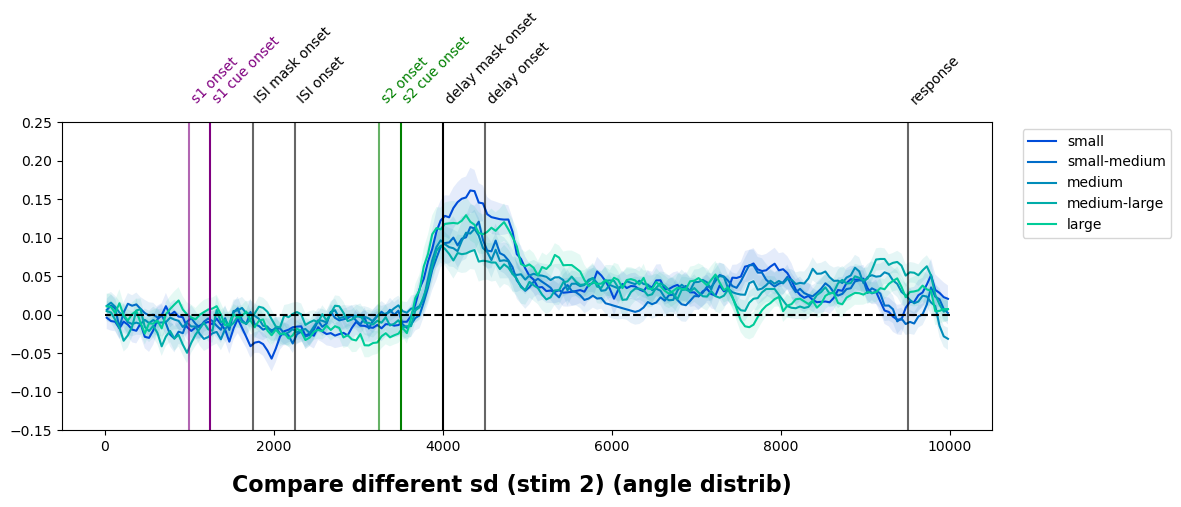

In [39]:
cmap = plt.get_cmap("winter")
plot_stim_sd_rsa('angle distrib', 'stim_2', 'stim 2', cmap)